<a href="https://colab.research.google.com/github/AhmedMaaouia1/UnblurAI/blob/main/2_Training_and_Evaluation_UNet_DIV2K_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training and Evaluation**

Objectif: Entraîner le modèle U-Net et évaluer les performances

Prérequis: Dataset préparé par 1_Data_Preparation_and_Compression.ipynb

Architecture: U-Net Enhanced avec skip connections

Métriques: PSNR, SSIM

Instructions d'exécution:
1. S'assurer que le notebook 1 a été exécuté (données dans /data/)
2. Exécuter les cellules dans l'ordre
3. L'entraînement prend ~2-4h sur GPU Colab (T4/V100)
4. Les résultats sont sauvegardés automatiquement dans Drive

## 1. Installation des Dépendances et Imports

Nous commençons par configurer notre environnement.

1.  **Installation des dépendances :** Nous installons deux bibliothèques qui ne sont pas incluses par défaut dans Colab :
    * `pytorch-msssim` : Essentielle pour calculer le **MS-SSIM (Multi-Scale Structural Similarity)**, une composante clé de notre fonction de perte hybride.
    * `scikit-image` : Utilisée pour son implémentation robuste du **PSNR (Peak Signal-to-Noise Ratio)**, notre principale métrique d'évaluation.

2.  **Imports :** Nous importons toutes les bibliothèques de base (`torch`, `pandas`, `PIL`) ainsi que les outils spécifiques à notre pipeline :
    * `BytesIO` : Une dépendance cruciale qui nous permet de simuler la compression JPEG en mémoire ("à la volée") sans jamais écrire de fichiers sur le disque.
    * `GradScaler` : Active la **précision mixte (AMP)** pour un entraînement plus rapide et plus économe en mémoire GPU.

3.  **Reproductibilité :** Nous fixons les graines aléatoires (`seed`) pour PyTorch, NumPy et Python. Cela garantit que toute personne exécutant ce notebook obtiendra les mêmes résultats (même initialisation des poids, même augmentation des données, etc.).

In [ ]:
!pip install pytorch-msssim -q
!pip install scikit-image -q

import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.cuda.amp import autocast, GradScaler

from pytorch_msssim import ssim, ms_ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Configuration reproductible
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## 2. Configuration des Données

### Connexion à Google Drive
La première étape est de connecter notre environnement Colab à Google Drive. C'est indispensable pour :
1.  **Accéder au Dataset :** Lire les images du dataset DIV2K (HR, LR) que nous avons préparées dans le notebook précédent.
2.  **Sauvegarder les Résultats :** Écrire nos modèles entraînés (`.pth`) et nos graphiques de résultats de manière persistante.

### Définition et Vérification des Chemins
Nous définissons ensuite une structure de dossiers propre et centralisée. Cette cellule vérifie que tous les répertoires nécessaires existent. C'est une étape de "garde-fou" (sanity check) cruciale : elle s'assure que le Notebook 1 (Préparation des données) a bien été exécuté avant de tenter de lancer l'entraînement.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Définition des chemins
BASE_PATH = "/content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K"
DATA_PATH = os.path.join(BASE_PATH, "data")
MODEL_PATH = os.path.join(BASE_PATH, "models")
RESULTS_PATH = os.path.join(BASE_PATH, "results")

# Vérification de l'existence des données
print("\nVérification de la présence des données...")

train_images_dir = os.path.join(DATA_PATH, "original", "DIV2K_train_HR")
compressed_train_dir = os.path.join(DATA_PATH, "compressed")
valid_images_dir = os.path.join(DATA_PATH, "valid", "original", "DIV2K_valid_HR")
compressed_valid_dir = os.path.join(DATA_PATH, "valid", "compressed")

# Vérifications
checks = [
    (train_images_dir, "Images train originales"),
    (compressed_train_dir, "Images train compressées"),
    (valid_images_dir, "Images validation originales"),
    (compressed_valid_dir, "Images validation compressées"),
]

all_ok = True
for path, name in checks:
    if os.path.exists(path):
        print(f"OK : {name}: {path}")
    else:
        print(f"NOT OK : {name}: INTROUVABLE - {path}")
        all_ok = False

if not all_ok:
    print("\nERREUR: Données manquantes!")
    print("Veuillez d'abord exécuter: 1_Data_Preparation_and_Compression.ipynb")
    raise FileNotFoundError("Dataset non préparé")

# Statistiques
num_train = len([f for f in os.listdir(train_images_dir) if f.endswith('.png')])
num_valid = len([f for f in os.listdir(valid_images_dir) if f.endswith('.png')])

print(f"\nStatistiques du dataset:")
print(f"   Images train: {num_train}")
print(f"   Images validation: {num_valid}")
print(f"   Qualités JPEG: Q5, Q10, Q20, Q30")

Mounted at /content/drive

Vérification de la présence des données...
OK : Images train originales: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/data/original/DIV2K_train_HR
OK : Images train compressées: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/data/compressed
OK : Images validation originales: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/data/valid/original/DIV2K_valid_HR
OK : Images validation compressées: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/data/valid/compressed

Statistiques du dataset:
   Images train: 800
   Images validation: 100
   Qualités JPEG: Q5, Q10, Q20, Q30


## 3. Définition du Dataset (Stratégie Dynamique)

C'est la cellule la plus importante de notre pipeline de données. Nous définissons la classe `DIV2K_JPEG_Dataset`.

### L'approche "à la volée" (On-the-fly)

Au lieu de lire des images statiques pré-compressées (ce qui limiterait notre modèle à 4 niveaux de qualité), nous implémentons une stratégie de **compression dynamique** :

1.  **`__init__`** : Le Dataset est initialisé en ne listant que les images **Haute Résolution (HR)** originales. Il ne connaît pas les images compressées.

2.  **`__getitem__`** : À chaque fois que le loader demande une image, cette fonction exécute le pipeline suivant :
    * Elle charge l'image HR originale.
    * **Sélection de Qualité Pondérée :** Elle choisit un facteur de qualité (Q) **aléatoire** dans la plage `[5, 30]`. Fait important, la sélection est *pondérée* (40% de chance d'avoir Q5-10) pour forcer le modèle à s'entraîner davantage sur les artefacts les plus sévères.
    * **Patching :** Elle extrait un patch aléatoire de 256x256.
    * **Compression Dynamique :** Elle appelle `_compress_jpeg` pour compresser ce patch en mémoire (via `BytesIO`) avec le facteur Q aléatoire.
    * **Augmentation :** Elle applique des transformations géométriques (flips horizontaux/verticaux, rotations) de manière identique sur le patch original et le patch compressé pour maintenir leur alignement.
    * **Normalisation & "Conditioning" :**
        * Les deux patchs sont normalisés dans la plage `[-1, 1]`.
        * Un 4ème canal (le "quality channel") est créé en copiant la valeur `quality / 100.0` sur toute la surface.
        * Ce canal est concaténé à l'image compressée pour créer l'entrée finale `(4, 256, 256)`.

Cette méthode transforme nos 800 images de base en une source de données quasi-infinie, forçant le modèle à apprendre la *relation* entre le niveau de qualité et les artefacts, plutôt que de mémoriser 4 cas statiques.

---
### Test du Dataset

À la fin de la cellule, nous instançons ce dataset et en extrayons un échantillon (`test_dataset[0]`) pour vérifier que tout fonctionne comme prévu.

In [ ]:
class DIV2K_JPEG_Dataset(Dataset):
    """
    Dataset PyTorch pour le training JPEG artifact removal avec compression aléatoire
    """

    def __init__(self, original_dir, patch_size=256, augmentation=True,
                 min_quality=5, max_quality=30):
        self.original_dir = original_dir
        self.filenames = sorted([f for f in os.listdir(original_dir)
                                if f.endswith('.png')])
        self.patch_size = patch_size
        self.augmentation = augmentation
        self.min_quality = min_quality
        self.max_quality = max_quality

        # Transformation avec normalisation [-1, 1]
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        print(f"Dataset initialisé: {len(self.filenames)} images")
        print(f"Compression JPEG aléatoire: Q ∈ [{min_quality}, {max_quality}]")
        print(f"Patch size: {patch_size}x{patch_size}")
        print(f"Normalisation: [-1, 1]")

    def __len__(self):
        return len(self.filenames)

    def _compress_jpeg(self, image, quality):
        """Applique une compression JPEG à la volée"""
        buffer = BytesIO()
        image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        compressed = Image.open(buffer).convert('RGB')
        return compressed

    def __getitem__(self, idx):
        # Charger l'image originale
        filename = self.filenames[idx]
        original_path = os.path.join(self.original_dir, filename)
        original = Image.open(original_path).convert('RGB')

        # Sélectionner aléatoirement un niveau de qualité (pondéré vers basses qualités)
        # Distribution: 40% Q5-10, 30% Q11-20, 30% Q21-30
        rand = random.random()
        if rand < 0.4:
            quality = random.randint(5, 10)
        elif rand < 0.7:
            quality = random.randint(11, 20)
        else:
            quality = random.randint(21, 30)

        # Extraction de patch aléatoire 256x256
        w, h = original.size
        if w >= self.patch_size and h >= self.patch_size:
            x = random.randint(0, w - self.patch_size)
            y = random.randint(0, h - self.patch_size)

            original = original.crop((x, y, x + self.patch_size, y + self.patch_size))
        else:
            # Si l'image est trop petite, resize
            original = original.resize((self.patch_size, self.patch_size), Image.BICUBIC)

        # Compression JPEG à la volée
        compressed = self._compress_jpeg(original, quality)

        # Augmentation de données
        if self.augmentation:
            # Flip horizontal
            if random.random() > 0.5:
                original = original.transpose(Image.FLIP_LEFT_RIGHT)
                compressed = compressed.transpose(Image.FLIP_LEFT_RIGHT)
            # Flip vertical
            if random.random() > 0.5:
                original = original.transpose(Image.FLIP_TOP_BOTTOM)
                compressed = compressed.transpose(Image.FLIP_TOP_BOTTOM)
            # Rotation 90° (avec probabilité 50%)
            if random.random() > 0.5:
                k = random.choice([1, 2, 3])  # 90°, 180°, 270°
                original = original.rotate(90 * k)
                compressed = compressed.rotate(90 * k)

        # Conversion en tenseur
        original_tensor = self.normalize(self.to_tensor(original))
        compressed_tensor = self.normalize(self.to_tensor(compressed))

        # Créer le canal de qualité normalisé [0, 1]
        quality_channel = torch.full(
            (1, self.patch_size, self.patch_size),
            quality / 100.0,
            dtype=torch.float32
        )

        # Concaténer le canal Q avec l'input (3 → 4 channels)
        input_with_quality = torch.cat([compressed_tensor, quality_channel], dim=0)

        return input_with_quality, original_tensor, quality


# Test du dataset
print("\nTest du dataset avec compression aléatoire...")
test_dataset = DIV2K_JPEG_Dataset(
    train_images_dir,
    patch_size=256,
    augmentation=True
)

print(f"\nTaille du dataset: {len(test_dataset)} images")

# Test d'un échantillon
sample_input, sample_target, sample_quality = test_dataset[0]
print(f"Shape input (JPEG + Q channel): {sample_input.shape}")
print(f"Shape target (Original): {sample_target.shape}")
print(f"Quality level: Q={sample_quality}")
print(f"Range input RGB: [{sample_input[:3].min():.3f}, {sample_input[:3].max():.3f}]")
print(f"Range quality channel: [{sample_input[3].min():.3f}, {sample_input[3].max():.3f}]")


Test du dataset avec compression aléatoire...
Dataset initialisé: 800 images
Compression JPEG aléatoire: Q ∈ [5, 30]
Patch size: 256x256
Normalisation: [-1, 1]

Taille du dataset: 800 images
Shape input (JPEG + Q channel): torch.Size([4, 256, 256])
Shape target (Original): torch.Size([3, 256, 256])
Quality level: Q=11
Range input RGB: [-1.000, 0.976]
Range quality channel: [0.110, 0.110]


La sortie du test confirme que notre `Dataset` est fonctionnel et correct :

1.  **Initialisation :** Le `Dataset` a bien trouvé les 800 images d'entraînement et a compris sa configuration (Q=5-30, patchs 256x256, normalisation [-1, 1]).
2.  **Formes (Shapes) :**
    * `Shape input` : `torch.Size([4, 256, 256])`. C'est correct, il s'agit des 3 canaux RGB plus notre canal de qualité.
    * `Shape target` : `torch.Size([3, 256, 256])`. C'est l'image HR originale, qui n'a que 3 canaux.
3.  **Qualité :** L'échantillon a été généré aléatoirement avec `Q=11`.
4.  **Plages (Ranges) :**
    * `Range input RGB` : `[-1.000, 0.976]`. Confirme que les données sont bien normalisées dans la plage `[-1, 1]`.
    * `Range quality channel` : `[0.110, 0.110]`. Confirme que le 4ème canal contient `11 / 100.0`.

Le pipeline de données est validé. Nous pouvons maintenant définir l'architecture du modèle qui recevra ces tenseurs.


---



## 4. Définition de l'Architecture (Res-U-Net)

Nous avons maintenant nos données d'entrée (4 canaux). Nous avons besoin d'un modèle pour les traiter. Cette cellule définit l'intégralité de notre architecture réseau.

### 4.1. Le Bloc de Construction : `ResidualBlock`

Plutôt qu'un simple `DoubleConv`, nous utilisons un `ResidualBlock` comme brique de base.
Un bloc résiduel (venant de ResNet) effectue deux convolutions mais ajoute également l'entrée originale (`x`) à la sortie (`out += residual`).

**Avantage :** Cela aide énormément le gradient à "circuler" à travers le réseau, permettant un entraînement plus stable et plus profond sans "disparition" du gradient.

### 4.2. L'Architecture Principale : `UNetEnhanced`

Nous implémentons une architecture **Res-U-Net**, qui combine la structure encodeur-décodeur d'un U-Net avec les `ResidualBlock`s que nous venons de définir.

**Points clés de cette architecture :**

1.  **Entrée 4 Canaux :** `in_channels=4`. L'encodeur `enc1` est conçu pour accepter le tenseur (RGB + Q) de notre Dataset.
2.  **Blocs Encodeurs/Décodeurs :** Chaque `_encoder_block` et `_decoder_block` utilise un `ResidualBlock`, rendant le réseau plus robuste.
3.  **Bottleneck :** Le "goulot d'étranglement" utilise des convolutions dilatées (`dilation=2`) pour augmenter le champ de réception (voir plus de contexte) sans coût de calcul supplémentaire.
4.  **Skip Connections :** La fusion des caractéristiques (ex: `torch.cat([dec4, enc4], dim=1)`) est gérée par une convolution 1x1 (`reduce4`), qui est une manière efficace d'aligner le nombre de canaux.
5.  **Apprentissage Résiduel (Sortie) :** Le modèle prédit un **delta** (le résidu).
6.  **Activation Finale `nn.Tanh()` :** C'est un choix de conception **crucial**.
    * Puisque nos images (entrée et cible) sont normalisées dans la plage `[-1, 1]`, le delta que nous prédisons devrait également se situer dans une plage similaire.
    * Le `nn.Tanh()` force la sortie finale du modèle à être bornée entre `[-1, 1]`. Cela stabilise l'entraînement et correspond parfaitement à notre pipeline de reconstruction résiduelle (traité dans `inference.py`).



In [ ]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """Bloc résiduel avec convolutions, BatchNorm et skip connection"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        return self.relu(out)


class UNetEnhanced(nn.Module):
    """
    U-Net Enhanced pour JPEG Artifact Removal avec sortie RÉSIDUELLE

    Changements:
    - in_channels=4 (RGB + canal Q/100)
    - Sortie résiduelle: prédit DELTA au lieu de l'image complète
    - Architecture identique sinon

    Paramètres: ~25M
    """

    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()

        # Encodeur (downsampling) - in_channels=4 pour RGB + Q
        self.enc1 = self._encoder_block(in_channels, 64)
        self.enc2 = self._encoder_block(64, 128)
        self.enc3 = self._encoder_block(128, 256)
        self.enc4 = self._encoder_block(256, 512)

        # Bottleneck avec convolutions dilatées
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=2, dilation=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            ResidualBlock(1024),
            ResidualBlock(1024),
            nn.Dropout2d(0.5)
        )

        # Décodeur (upsampling)
        self.dec4 = self._decoder_block(1024, 512)
        self.dec3 = self._decoder_block(512, 256)
        self.dec2 = self._decoder_block(256, 128)
        self.dec1 = self._decoder_block(128, 64)

        # Couches de réduction pour les skip connections
        self.reduce4 = nn.Conv2d(1024, 512, 1)
        self.reduce3 = nn.Conv2d(512, 256, 1)
        self.reduce2 = nn.Conv2d(256, 128, 1)
        self.reduce1 = nn.Conv2d(128, 64, 1)

        # Couche de sortie RÉSIDUELLE (Tanh pour delta [-1, 1])
        self.final = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, 1),
            nn.Tanh()  # Delta dans [-1, 1]
        )

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def _encoder_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            ResidualBlock(out_ch),
            nn.Dropout2d(0.1)
        )

    def _decoder_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            ResidualBlock(out_ch),
            nn.Dropout2d(0.1)
        )

    def _align_tensors(self, dec, enc):
        """
        Aligne les tenseurs décodeur et encodeur avec padding si nécessaire

        Args:
            dec: tenseur du décodeur (après upsampling)
            enc: tenseur de l'encodeur (skip connection)

        Returns:
            dec: tenseur décodeur paddé pour matcher la taille de enc
        """
        if dec.size() != enc.size():
            diffY = enc.size(2) - dec.size(2)
            diffX = enc.size(3) - dec.size(3)

            # Padding: [left, right, top, bottom]
            dec = F.pad(dec, [diffX // 2, diffX - diffX // 2,
                             diffY // 2, diffY - diffY // 2])

        return dec

    def forward(self, x):
        # x contient 4 canaux: RGB + Q
        # Encodeur avec sauvegarde des features
        enc1 = self.enc1(x)                    # [B, 64, H, W]
        enc2 = self.enc2(self.pool(enc1))      # [B, 128, H/2, W/2]
        enc3 = self.enc3(self.pool(enc2))      # [B, 256, H/4, W/4]
        enc4 = self.enc4(self.pool(enc3))      # [B, 512, H/8, W/8]

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))  # [B, 1024, H/16, W/16]

        # Décodeur avec skip connections et alignement automatique
        dec4 = self.dec4(self.upsample(bottleneck))    # [B, 512, H/8, W/8]
        dec4 = self._align_tensors(dec4, enc4)         # Alignement si nécessaire
        dec4 = self.reduce4(torch.cat([dec4, enc4], dim=1))

        dec3 = self.dec3(self.upsample(dec4))          # [B, 256, H/4, W/4]
        dec3 = self._align_tensors(dec3, enc3)
        dec3 = self.reduce3(torch.cat([dec3, enc3], dim=1))

        dec2 = self.dec2(self.upsample(dec3))          # [B, 128, H/2, W/2]
        dec2 = self._align_tensors(dec2, enc2)
        dec2 = self.reduce2(torch.cat([dec2, enc2], dim=1))

        dec1 = self.dec1(self.upsample(dec2))          # [B, 64, H, W]
        dec1 = self._align_tensors(dec1, enc1)
        dec1 = self.reduce1(torch.cat([dec1, enc1], dim=1))

        # Sortie RÉSIDUELLE (delta)
        delta = self.final(dec1)

        return delta

### 4.3. Test de Validation de l'Architecture (Sanity Check)

Maintenant que la classe `UNetEnhanced` est définie, nous allons :
1.  **Initialiser le modèle** avec les bons paramètres (`in_channels=4`) et le déplacer sur le `device` disponible (le GPU `cuda` si possible).
2.  **Compter les paramètres** : Nous calculons le nombre total de poids dans le réseau. C'est une métrique importante pour évaluer la "taille" et la complexité de notre modèle.
3.  **Effectuer un Test de "Forward Pass"** : C'est un test essentiel. Nous créons un tenseur aléatoire (un "dummy input") avec 4 canaux et nous le passons dans le modèle.
    * Nous testons plusieurs tailles d'image (256x256, 257x257, 255x255) pour vérifier que notre fonction `_align_tensors` (qui gère le padding) fonctionne.
    * Si le modèle réussit ce test, cela prouve qu'il peut gérer des images de n'importe quelle taille sans crasher.

In [ ]:
# Initialisation du modèle avec 4 canaux d'entrée
print("\nInitialisation du modèle U-Net Enhanced avec:")
print("   - in_channels=4 (RGB + Q/100)")
print("   - Sortie résiduelle (delta)")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetEnhanced(in_channels=4, out_channels=3).to(device)

# Calcul du nombre de paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Modèle U-Net Enhanced créé")
print(f"Device: {device}")
print(f"Paramètres totaux: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"Paramètres entraînables: {trainable_params:,}")

# Test forward pass avec 4 canaux
test_sizes = [(256, 256), (257, 257), (255, 255)]
for h, w in test_sizes:
    test_input = torch.randn(1, 4, h, w).to(device)  # 4 canaux
    with torch.no_grad():
        test_delta = model(test_input)
    print(f"Test {h}x{w}: input {test_input.shape} → delta {test_delta.shape}")


Initialisation du modèle U-Net Enhanced avec:
   - in_channels=4 (RGB + Q/100)
   - Sortie résiduelle (delta)
Modèle U-Net Enhanced créé
Device: cuda
Paramètres totaux: 63,585,731 (63.59M)
Paramètres entraînables: 63,585,731
Test 256x256: input torch.Size([1, 4, 256, 256]) → delta torch.Size([1, 3, 256, 256])
Test 257x257: input torch.Size([1, 4, 257, 257]) → delta torch.Size([1, 3, 257, 257])
Test 255x255: input torch.Size([1, 4, 255, 255]) → delta torch.Size([1, 3, 255, 255])


Le test de validation est un succès :

1.  **Initialisation :** Le modèle a été créé avec succès et est prêt à être utilisé sur le GPU (`Device: cuda`).
2.  **Taille du Modèle :** Le réseau a **63.59 millions de paramètres**. C'est un modèle de taille considérable, ce qui est attendu pour une tâche complexe de restauration d'image haute-fidélité.
3.  **Test "Forward Pass" :** C'est le résultat le plus important.
    * Le modèle a correctement accepté une entrée `[1, 4, H, W]` (Batch=1, 4 Canaux).
    * Il a retourné une sortie `[1, 3, H, W]` (Batch=1, 3 Canaux pour le delta).
    * Il a fonctionné pour des tailles paires (256x256) et impaires (257, 255), confirmant que notre logique de padding dans `_align_tensors` est robuste et que notre modèle est entièrement convolutif.



---

## 5. Définition de la Fonction de Perte Hybride

Nous ne pouvons pas nous contenter d'une simple perte L1 ou MSE. Ces métriques optimisent la précision pixel-à-pixel mais ignorent la perception humaine, ce qui conduit à des résultats flous.

Pour équilibrer la **fidélité** (PSNR) et la **qualité perceptuelle** (SSIM), nous définissons une fonction de perte hybride (`CombinedLoss`) composée de trois éléments.

### 5.1. `CharbonnierLoss`
C'est une version lissée de la perte L1 (`sqrt(diff^2 + epsilon^2)`). Elle est moins sensible aux pixels aberrants (outliers) que la perte L2 (MSE) et est réputée pour produire des résultats visuellement agréables avec une bonne fidélité.

### 5.2. `EdgeLoss`
C'est notre composant "netteté". Nous créons un filtre de Sobel pour extraire la magnitude du gradient (les "contours") de l'image prédite et de l'image cible. Nous appliquons ensuite une perte L1 entre ces deux cartes de contours.
**Objectif :** Forcer le modèle à prêter attention aux détails fins et à produire des bords nets, combattant ainsi le "flou" typique des modèles de restauration.

### 5.3. `CombinedLoss`
Ici, nous assemblons les pièces avec une pondération stratégique pour guider le modèle :
- **`0.5 * Charbonnier` :** La majorité de la perte vient de la fidélité de base.
- **`0.3 * MS-SSIM` :** Un poids important est donné à la similarité structurelle multi-échelle. Notez que nous minimisons `1 - ms_ssim`.
- **`0.2 * EdgeLoss` :** Un poids plus faible, mais crucial, pour la préservation des contours.

À la fin, la cellule teste que notre `CombinedLoss` fonctionne en lui passant deux tenseurs aléatoires et en vérifiant les sorties.

In [ ]:
class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (smooth L1) - robuste aux outliers"""
    def __init__(self, epsilon=1e-3):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        diff = pred - target
        loss = torch.sqrt(diff * diff + self.epsilon * self.epsilon)
        return torch.mean(loss)


class EdgeLoss(nn.Module):
    """Edge Loss basée sur les gradients Sobel"""
    def __init__(self):
        super().__init__()
        # Filtres Sobel
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)

        self.sobel_x = sobel_x.view(1, 1, 3, 3).repeat(3, 1, 1, 1)
        self.sobel_y = sobel_y.view(1, 1, 3, 3).repeat(3, 1, 1, 1)

    def forward(self, pred, target):
        if self.sobel_x.device != pred.device:
            self.sobel_x = self.sobel_x.to(pred.device)
            self.sobel_y = self.sobel_y.to(pred.device)

        # Gradients de pred
        pred_grad_x = F.conv2d(pred, self.sobel_x, padding=1, groups=3)
        pred_grad_y = F.conv2d(pred, self.sobel_y, padding=1, groups=3)
        pred_edges = torch.sqrt(pred_grad_x**2 + pred_grad_y**2 + 1e-6)

        # Gradients de target
        target_grad_x = F.conv2d(target, self.sobel_x, padding=1, groups=3)
        target_grad_y = F.conv2d(target, self.sobel_y, padding=1, groups=3)
        target_edges = torch.sqrt(target_grad_x**2 + target_grad_y**2 + 1e-6)

        # L1 sur les edges
        return F.l1_loss(pred_edges, target_edges)


class CombinedLoss(nn.Module):
    """
    Loss combinée orientée DÉTAILS:
    - 0.5 * Charbonnier (robuste aux outliers)
    - 0.3 * MS-SSIM (multi-scale structure)
    - 0.2 * Edge (préservation des contours)

    Args:
        device: cuda ou cpu
    """

    def __init__(self, device):
        super().__init__()
        self.charbonnier = CharbonnierLoss(epsilon=1e-3)
        self.edge = EdgeLoss()
        self.device = device

        # Poids de la loss
        self.w_char = 0.5
        self.w_ssim = 0.3
        self.w_edge = 0.2

    def forward(self, pred, target):
        # Charbonnier loss
        char_loss = self.charbonnier(pred, target)

        # MS-SSIM loss (minimiser 1 - MS-SSIM)
        # data_range=2.0 car normalisation [-1, 1]
        ms_ssim_val = ms_ssim(pred, target, data_range=2.0, size_average=True)
        ms_ssim_loss = 1 - ms_ssim_val

        # Edge loss
        edge_loss = self.edge(pred, target)

        # Combinaison pondérée
        total_loss = (
            self.w_char * char_loss +
            self.w_ssim * ms_ssim_loss +
            self.w_edge * edge_loss
        )

        return total_loss, char_loss.item(), ms_ssim_val.item(), edge_loss.item()


# Test de la fonction de perte
criterion = CombinedLoss(device=device)

test_pred = torch.randn(2, 3, 256, 256).to(device)
test_target = torch.randn(2, 3, 256, 256).to(device)

total, char, ms_ssim_val, edge = criterion(test_pred, test_target)
print(f"Nouvelle fonction de perte testée")
print(f"   Loss totale: {total.item():.4f}")
print(f"   Charbonnier: {char:.4f} (poids: {criterion.w_char})")
print(f"   MS-SSIM: {ms_ssim_val:.4f} (poids: {criterion.w_ssim})")
print(f"   Edge: {edge:.4f} (poids: {criterion.w_edge})")
print(f"   Formule: {criterion.w_char}*Char + {criterion.w_ssim}*(1-MS-SSIM) + {criterion.w_edge}*Edge")

Nouvelle fonction de perte testée
   Loss totale: 1.3630
   Charbonnier: 1.1260 (poids: 0.5)
   MS-SSIM: 0.0218 (poids: 0.3)
   Edge: 2.5326 (poids: 0.2)
   Formule: 0.5*Char + 0.3*(1-MS-SSIM) + 0.2*Edge


Le test a réussi.

1.  **Exécution :** La fonction de perte combinée s'est exécutée sans erreur.
2.  **Sorties :** Elle a correctement retourné la perte totale (`total_loss`) ainsi que les valeurs individuelles de chaque composante (`char`, `ms_ssim_val`, `edge`).
3.  **Validation de la Formule :** La sortie confirme la formule de pondération appliquée.

Notre fonction de perte est prête. Nous pouvons maintenant définir les boucles d'entraînement et de validation qui l'utiliseront.



---



## 6. Configuration de l'Entraînement

C'est la dernière étape de configuration avant de lancer l'entraînement. Cette cellule rassemble toutes les pièces que nous avons définies précédemment :

1.  **Hyperparamètres :** Définition des constantes de l'entraînement (`BATCH_SIZE`, `LEARNING_RATE`, `NUM_EPOCHS`).
2.  **Dataset :** Instanciation de notre `DIV2K_JPEG_Dataset`. Notez que nous n'utilisons *que* le `train_images_dir` (les originaux HR). Le dataset gère la compression aléatoire à la volée, ignorant les dossiers statiques.
3.  **DataLoader :** Le `Dataset` est encapsulé dans un `DataLoader` qui gérera le "batching" et le chargement multi-thread (`num_workers=2`) pour ne pas ralentir le GPU.
4.  **Composants d'Entraînement :**
    * **Perte :** Instanciation de notre `CombinedLoss` .
    * **Optimiseur :** Nous choisissons `Adam`, un optimiseur robuste et efficace.
    * **Scheduler :** Nous configurons un `ReduceLROnPlateau`. Celui-ci surveillera la perte de validation (`mode='min'`) et réduira automatiquement le learning rate (`factor=0.5`) si la performance stagne pendant 5 époques (`patience=5`). C'est une technique clé pour un affinage de précision vers la fin de l'entraînement.
    * **Précision Mixte (AMP) :** Le `GradScaler` est activé pour accélérer l'entraînement et réduire l'utilisation de la VRAM du GPU.

In [ ]:
# Hyperparamètres
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6
NUM_EPOCHS = 60
SAVE_EVERY = 3
KEEP_LAST_N = 2

print("\nConfiguration de l'entraînement (optimisée):")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Loss: 0.5*Charbonnier + 0.3*MS-SSIM + 0.2*Edge")
print(f"   Device: {device}")

# Dataset avec compression aléatoire (ne charge plus les dossiers Q5/Q10/Q20/Q30)
train_dataset = DIV2K_JPEG_Dataset(
    train_images_dir,
    patch_size=256,
    augmentation=True,
    min_quality=5,
    max_quality=30
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"   Steps par epoch: {len(train_loader)}")
print(f"   Total iterations: {NUM_EPOCHS * len(train_loader)}")

# Nouvelle fonction de perte
criterion = CombinedLoss(device=device)

# Optimiseur
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Scheduler dynamique ReduceLROnPlateau (SANS verbose)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Minimiser la loss
    factor=0.5,           # Réduire LR de 50%
    patience=5,           # Attendre 5 epochs sans amélioration
    min_lr=1e-7,          # LR minimale
    threshold=1e-4        # Seuil d'amélioration significative
)

# Mixed precision scaler
scaler = GradScaler()

print(f"Optimiseur: Adam")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"Mixed precision: activée")


Configuration de l'entraînement (optimisée):
   Batch size: 8
   Learning rate: 0.0001
   Epochs: 60
   Loss: 0.5*Charbonnier + 0.3*MS-SSIM + 0.2*Edge
   Device: cuda
Dataset initialisé: 800 images
Compression JPEG aléatoire: Q ∈ [5, 30]
Patch size: 256x256
Normalisation: [-1, 1]
   Steps par epoch: 100
   Total iterations: 6000
Optimiseur: Adam
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
Mixed precision: activée


/tmp/ipython-input-2443665672.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


La configuration est maintenant chargée et prête.

1.  **Configuration :** Tous nos hyperparamètres (Batch Size 8, LR 1e-4, 60 Epochs) et la formule de perte sont confirmés.
2.  **Taille de l'Époque :** La sortie confirme nos calculs : avec 800 images et un `BATCH_SIZE` de 8, chaque époque nécessitera **100 "steps"** (itérations).
3.  **Entraînement Total :** L'entraînement complet durera **6000 itérations** (100 steps/epoch * 60 epochs).
4.  **Outils :** L'optimiseur `Adam`, le `Scheduler` dynamique et la `GradScaler` (précision mixte) sont tous initialisés.

*(L'avertissement (`FutureWarning`) sur le `GradScaler` est une note d'information de PyTorch et n'affecte pas notre exécution).*

Tous les composants sont assemblés. Nous pouvons lancer la boucle d'entraînement principale.



---



## 7. Fonctions Utilitaires : Sauvegarde et Reprise

Avant de lancer la boucle principale, nous définissons des fonctions d'aide pour gérer la sauvegarde de notre modèle. C'est crucial pour deux raisons :
1.  **Sauvegarder le Progrès :** Si Colab se déconnecte après 2 heures d'entraînement, nous ne voulons pas tout perdre.
2.  **Reprendre l'Entraînement :** Nous devons être capables de recharger le dernier état du modèle pour reprendre là où nous nous étions arrêtés.

Cette cellule définit trois fonctions :

- **`save_checkpoint` :** Sauvegarde un "checkpoint" complet, qui inclut non seulement les poids du modèle (`model_state_dict`), mais aussi l'état de l'optimiseur (`optimizer_state_dict`), l'époque actuelle et la perte.
- **`load_checkpoint` :** La fonction inverse, qui recharge tous ces états pour reprendre l'entraînement de manière transparente.
- **`cleanup_old_checkpoints` :** Une fonction "de ménage" pour éviter de saturer notre Google Drive. Elle supprime tous les anciens checkpoints pour ne garder que les `keep_last_n` plus récents.

Enfin, le script vérifie si un checkpoint existe déjà dans le dossier `models/`. Si c'est le cas, il le charge automatiquement et règle `start_epoch` pour reprendre l'entraînement.

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, is_best=False):
    """Sauvegarde un checkpoint du modèle"""

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    if is_best:
        path = os.path.join(MODEL_PATH, "best_model.pth")
        torch.save(checkpoint, path)
        print(f"Meilleur modèle sauvegardé: {path}")
    else:
        path = os.path.join(MODEL_PATH, f"checkpoint_epoch_{epoch}.pth")
        torch.save(checkpoint, path)
        print(f"Checkpoint sauvegardé: epoch {epoch}")

    return path


def load_checkpoint(model, optimizer, checkpoint_path):
    """Charge un checkpoint"""

    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint introuvable: {checkpoint_path}")
        return 0

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"Checkpoint chargé: epoch {epoch}, loss {loss:.4f}")
    return epoch


def cleanup_old_checkpoints(models_dir, keep_last_n=2):
    """Supprime les anciens checkpoints"""

    checkpoints = [f for f in os.listdir(models_dir)
                   if f.startswith("checkpoint_epoch_") and f.endswith(".pth")]

    if len(checkpoints) <= keep_last_n:
        return

    checkpoints.sort(key=lambda x: int(x.split("_")[2].replace(".pth", "")))
    to_delete = checkpoints[:-keep_last_n]

    for ckpt in to_delete:
        path = os.path.join(models_dir, ckpt)
        os.remove(path)
        print(f"Supprimé: {ckpt}")


# Vérifier si un checkpoint existe
checkpoints = [f for f in os.listdir(MODEL_PATH)
               if f.startswith("checkpoint_") and f.endswith(".pth")]

start_epoch = 0
if checkpoints:
    latest = sorted(checkpoints)[-1]
    latest_path = os.path.join(MODEL_PATH, latest)
    start_epoch = load_checkpoint(model, optimizer, latest_path) + 1
    print(f"Reprise de l'entraînement à l'epoch {start_epoch}")



---


## 8. Lancement de l'Entraînement Principal

Nous avons maintenant tous nos composants : le Dataset, le Modèle, la Perte, et l'Optimiseur. Cette cellule orchestre l'ensemble du processus d'entraînement.

### 8.1. La Fonction `train_one_epoch`

Cette fonction définit la logique d'une seule passe sur l'ensemble des données d'entraînement.

L'étape la plus critique est l'implémentation de **l'apprentissage résiduel** (lignes 28-36) :

1.  **Prédiction du Delta (L. 28) :** Le modèle ne prédit pas l'image finale. Il reçoit l'entrée 4D (`inputs`) et prédit un `delta` (le résidu, ou la "correction" à appliquer).
2.  **Isolation de l'Entrée (L. 31) :** Nous extrayons les 3 canaux RGB de l'image d'entrée (`compressed_rgb`).
3.  **Reconstruction (L. 32) :** Nous appliquons la correction : `restored = compressed_rgb + delta`. C'est l'image restaurée.
4.  **Clipping (L. 35) :** Puisque notre `delta` (prédit par `Tanh`) et notre `input_rgb` sont tous deux dans la plage `[-1, 1]`, leur addition peut dépasser cette plage (allant de -2 à +2). Nous devons "clipper" (ramener) le résultat dans la plage `[-1, 1]` avant de le passer à la fonction de perte.
5.  **Calcul de la Perte (L. 38) :** La `CombinedLoss` est calculée en comparant l'image *restaurée* (`restored`) à la cible (`targets`).

La fonction gère également la précision mixte (`autocast` et `scaler`) pour accélérer l'entraînement.

### 8.2. La Boucle Principale

La deuxième partie de la cellule est la boucle d'itération (`for epoch in ...`) :

- Elle appelle `train_one_epoch` pour chaque époque.
- Elle enregistre les métriques (Loss, MS-SSIM, etc.) pour le traçage futur.
- Elle appelle `scheduler.step(epoch_loss)`, qui réduit le Learning Rate si la perte stagne (selon notre configuration `ReduceLROnPlateau`).
- Elle compare la perte de l'époque actuelle à la `best_loss` et appelle `save_checkpoint(..., is_best=True)` si un nouveau record est atteint.
- Elle gère la sauvegarde périodique et le nettoyage des anciens checkpoints.

In [ ]:
"""Boucle d'entraînement avec sortie RÉSIDUELLE"""






def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch):
    """Entraîne le modèle pour une epoch avec résidual learning"""

    model.train()
    running_loss = 0.0
    running_char = 0.0
    running_ms_ssim = 0.0
    running_edge = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_idx, (inputs, targets, qualities) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs shape: [B, 4, H, W] (RGB + Q channel)
        # targets shape: [B, 3, H, W] (RGB original)

        optimizer.zero_grad()

        # Forward pass avec mixed precision
        with autocast():
            # Le modèle prédit le DELTA
            delta = model(inputs)

            # Reconstruction: restored = compressed_rgb + delta
            compressed_rgb = inputs[:, :3, :, :]  # Extraire les 3 premiers canaux RGB
            restored = compressed_rgb + delta

            # Clipper dans [-1, 1] (range de normalisation)
            restored = torch.clamp(restored, -1, 1)

            # Calcul de la loss sur l'image restaurée
            loss, char, ms_ssim_val, edge = criterion(restored, targets)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistiques
        running_loss += loss.item()
        running_char += char
        running_ms_ssim += ms_ssim_val
        running_edge += edge

        # Mise à jour de la barre de progression
        if batch_idx % 10 == 0:
            avg_loss = running_loss / (batch_idx + 1)
            avg_ms_ssim = running_ms_ssim / (batch_idx + 1)
            pbar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'ms_ssim': f'{avg_ms_ssim:.4f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

    # Moyennes sur l'epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_char = running_char / len(train_loader)
    epoch_ms_ssim = running_ms_ssim / len(train_loader)
    epoch_edge = running_edge / len(train_loader)

    return epoch_loss, epoch_char, epoch_ms_ssim, epoch_edge


# Initialisation du tracking
best_loss = float('inf')
train_losses = []
train_char_losses = []
train_ms_ssim_values = []
train_edge_losses = []
learning_rates = []

print("\n" + "="*70)
print(" DÉBUT DE L'ENTRAÎNEMENT (Résidual Learning)")
print("="*70)

# Mesure du temps total
total_start_time = time.time()

# Boucle d'entraînement
for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start_time = time.time()

    # Entraînement
    epoch_loss, epoch_char, epoch_ms_ssim, epoch_edge = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device, epoch
    )

    # Sauvegarde des métriques
    train_losses.append(epoch_loss)
    train_char_losses.append(epoch_char)
    train_ms_ssim_values.append(epoch_ms_ssim)
    train_edge_losses.append(epoch_edge)

    # Learning rate scheduling dynamique (basé sur la loss)
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(epoch_loss)
    new_lr = optimizer.param_groups[0]['lr']

    learning_rates.append(new_lr)

    # Détection et affichage des changements de LR
    if new_lr != current_lr:
        print(f"\nLearning Rate réduit: {current_lr:.2e} → {new_lr:.2e}")

    epoch_time = time.time() - epoch_start_time

    # Affichage
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} terminée en {epoch_time:.1f}s")
    print(f"   Loss: {epoch_loss:.4f} | Char: {epoch_char:.4f} | MS-SSIM: {epoch_ms_ssim:.4f} | Edge: {epoch_edge:.4f}")
    print(f"   LR: {new_lr:.2e}")

    # Sauvegarde du meilleur modèle
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        save_checkpoint(model, optimizer, epoch, epoch_loss, is_best=True)
        print(f"   *** Nouveau meilleur modèle!")

    # Sauvegarde périodique
    if (epoch + 1) % SAVE_EVERY == 0:
        save_checkpoint(model, optimizer, epoch, epoch_loss, is_best=False)
        cleanup_old_checkpoints(MODEL_PATH, keep_last_n=KEEP_LAST_N)

    print("-" * 70)

# Temps total
total_time = time.time() - total_start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

print("\n" + "="*70)
print("* ENTRAÎNEMENT TERMINÉ!")
print("="*70)
print(f"- Durée totale: {hours}h {minutes}m {seconds}s")
print(f"- Meilleure loss: {best_loss:.4f}")
print(f"- LR finale: {optimizer.param_groups[0]['lr']:.2e}")
print(f"- Modèle sauvegardé dans: {MODEL_PATH}")
print("="*70 + "\n")


 DÉBUT DE L'ENTRAÎNEMENT (Résidual Learning)


Epoch 1/60:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-2827654337.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1/60 terminée en 153.8s
   Loss: 0.1559 | Char: 0.1175 | MS-SSIM: 0.8539 | Edge: 0.2666
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 2/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 2/60 terminée en 90.6s
   Loss: 0.1078 | Char: 0.0716 | MS-SSIM: 0.9151 | Edge: 0.2324
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 3/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 3/60 terminée en 117.1s
   Loss: 0.1036 | Char: 0.0675 | MS-SSIM: 0.9186 | Edge: 0.2273
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
Checkpoint sauvegardé: epoch 2
----------------------------------------------------------------------


Epoch 4/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 4/60 terminée en 91.6s
   Loss: 0.1027 | Char: 0.0664 | MS-SSIM: 0.9205 | Edge: 0.2282
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 5/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 5/60 terminée en 117.7s
   Loss: 0.1005 | Char: 0.0646 | MS-SSIM: 0.9224 | Edge: 0.2248
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 6/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 6/60 terminée en 118.5s
   Loss: 0.0984 | Char: 0.0634 | MS-SSIM: 0.9238 | Edge: 0.2191
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
Checkpoint sauvegardé: epoch 5
----------------------------------------------------------------------


Epoch 7/60:   0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 7/60 terminée en 127.7s
   Loss: 0.0981 | Char: 0.0631 | MS-SSIM: 0.9247 | Edge: 0.2196
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 8/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 8/60 terminée en 120.6s
   Loss: 0.0957 | Char: 0.0617 | MS-SSIM: 0.9279 | Edge: 0.2159
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 9/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 9/60 terminée en 120.2s
   Loss: 0.0927 | Char: 0.0597 | MS-SSIM: 0.9299 | Edge: 0.2090
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
Checkpoint sauvegardé: epoch 8
Supprimé: checkpoint_epoch_2.pth
----------------------------------------------------------------------


Epoch 10/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 10/60 terminée en 125.8s
   Loss: 0.0972 | Char: 0.0627 | MS-SSIM: 0.9282 | Edge: 0.2216
   LR: 1.00e-04
----------------------------------------------------------------------


Epoch 11/60:   0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 11/60 terminée en 92.8s
   Loss: 0.0950 | Char: 0.0612 | MS-SSIM: 0.9290 | Edge: 0.2156
   LR: 1.00e-04
----------------------------------------------------------------------


Epoch 12/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 12/60 terminée en 89.3s
   Loss: 0.0960 | Char: 0.0622 | MS-SSIM: 0.9302 | Edge: 0.2197
   LR: 1.00e-04
Checkpoint sauvegardé: epoch 11
Supprimé: checkpoint_epoch_5.pth
----------------------------------------------------------------------


Epoch 13/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 13/60 terminée en 91.7s
   Loss: 0.0957 | Char: 0.0614 | MS-SSIM: 0.9272 | Edge: 0.2159
   LR: 1.00e-04
----------------------------------------------------------------------


Epoch 14/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 14/60 terminée en 89.4s
   Loss: 0.0925 | Char: 0.0596 | MS-SSIM: 0.9302 | Edge: 0.2090
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 15/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 15/60 terminée en 121.2s
   Loss: 0.0959 | Char: 0.0614 | MS-SSIM: 0.9285 | Edge: 0.2190
   LR: 1.00e-04
Checkpoint sauvegardé: epoch 14
Supprimé: checkpoint_epoch_8.pth
----------------------------------------------------------------------


Epoch 16/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 16/60 terminée en 94.7s
   Loss: 0.0893 | Char: 0.0581 | MS-SSIM: 0.9365 | Edge: 0.2057
   LR: 1.00e-04
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 17/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 17/60 terminée en 90.9s
   Loss: 0.0956 | Char: 0.0613 | MS-SSIM: 0.9294 | Edge: 0.2189
   LR: 1.00e-04
----------------------------------------------------------------------


Epoch 18/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 18/60 terminée en 88.7s
   Loss: 0.0914 | Char: 0.0587 | MS-SSIM: 0.9314 | Edge: 0.2076
   LR: 1.00e-04
Checkpoint sauvegardé: epoch 17
Supprimé: checkpoint_epoch_11.pth
----------------------------------------------------------------------


Epoch 19/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 19/60 terminée en 92.1s
   Loss: 0.0898 | Char: 0.0578 | MS-SSIM: 0.9341 | Edge: 0.2053
   LR: 1.00e-04
----------------------------------------------------------------------


Epoch 20/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 20/60 terminée en 89.6s
   Loss: 0.0915 | Char: 0.0593 | MS-SSIM: 0.9329 | Edge: 0.2087
   LR: 1.00e-04
----------------------------------------------------------------------


Epoch 21/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 21/60 terminée en 89.9s
   Loss: 0.0920 | Char: 0.0593 | MS-SSIM: 0.9310 | Edge: 0.2083
   LR: 1.00e-04
Checkpoint sauvegardé: epoch 20
Supprimé: checkpoint_epoch_14.pth
----------------------------------------------------------------------


Epoch 22/60:   0%|          | 0/100 [00:00<?, ?it/s]


Learning Rate réduit: 1.00e-04 → 5.00e-05

Epoch 22/60 terminée en 93.4s
   Loss: 0.0908 | Char: 0.0590 | MS-SSIM: 0.9349 | Edge: 0.2089
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 23/60:   0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 23/60 terminée en 97.1s
   Loss: 0.0920 | Char: 0.0591 | MS-SSIM: 0.9328 | Edge: 0.2118
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 24/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 24/60 terminée en 90.1s
   Loss: 0.0927 | Char: 0.0602 | MS-SSIM: 0.9340 | Edge: 0.2137
   LR: 5.00e-05
Checkpoint sauvegardé: epoch 23
Supprimé: checkpoint_epoch_17.pth
----------------------------------------------------------------------


Epoch 25/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 25/60 terminée en 94.1s
   Loss: 0.0901 | Char: 0.0581 | MS-SSIM: 0.9365 | Edge: 0.2099
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 26/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 26/60 terminée en 89.4s
   Loss: 0.0914 | Char: 0.0591 | MS-SSIM: 0.9351 | Edge: 0.2118
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 27/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 27/60 terminée en 90.7s
   Loss: 0.0882 | Char: 0.0571 | MS-SSIM: 0.9366 | Edge: 0.2032
   LR: 5.00e-05
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
Checkpoint sauvegardé: epoch 26
Supprimé: checkpoint_epoch_20.pth
----------------------------------------------------------------------


Epoch 28/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 28/60 terminée en 127.6s
   Loss: 0.0900 | Char: 0.0581 | MS-SSIM: 0.9350 | Edge: 0.2070
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 29/60:   0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1610, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/


Epoch 29/60 terminée en 99.6s
   Loss: 0.0882 | Char: 0.0574 | MS-SSIM: 0.9386 | Edge: 0.2054
   LR: 5.00e-05
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 30/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 30/60 terminée en 121.6s
   Loss: 0.0913 | Char: 0.0587 | MS-SSIM: 0.9338 | Edge: 0.2106
   LR: 5.00e-05
Checkpoint sauvegardé: epoch 29
Supprimé: checkpoint_epoch_23.pth
----------------------------------------------------------------------


Epoch 31/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 31/60 terminée en 93.1s
   Loss: 0.0927 | Char: 0.0597 | MS-SSIM: 0.9333 | Edge: 0.2142
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 32/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 32/60 terminée en 91.6s
   Loss: 0.0900 | Char: 0.0581 | MS-SSIM: 0.9361 | Edge: 0.2085
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 33/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 33/60 terminée en 90.3s
   Loss: 0.0905 | Char: 0.0581 | MS-SSIM: 0.9347 | Edge: 0.2094
   LR: 5.00e-05
Checkpoint sauvegardé: epoch 32
Supprimé: checkpoint_epoch_26.pth
----------------------------------------------------------------------


Epoch 34/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 34/60 terminée en 94.7s
   Loss: 0.0906 | Char: 0.0585 | MS-SSIM: 0.9356 | Edge: 0.2100
   LR: 5.00e-05
----------------------------------------------------------------------


Epoch 35/60:   0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b24d81a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Learning Rate réduit: 5.00e-05 → 2.50e-05

Epoch 35/60 terminée en 94.2s
   Loss: 0.0903 | Char: 0.0583 | MS-SSIM: 0.9366 | Edge: 0.2105
   LR: 2.50e-05
----------------------------------------------------------------------


Epoch 36/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 36/60 terminée en 90.0s
   Loss: 0.0889 | Char: 0.0575 | MS-SSIM: 0.9373 | Edge: 0.2069
   LR: 2.50e-05
Checkpoint sauvegardé: epoch 35
Supprimé: checkpoint_epoch_29.pth
----------------------------------------------------------------------


Epoch 37/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 37/60 terminée en 93.6s
   Loss: 0.0892 | Char: 0.0574 | MS-SSIM: 0.9352 | Edge: 0.2053
   LR: 2.50e-05
----------------------------------------------------------------------


Epoch 38/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 38/60 terminée en 90.4s
   Loss: 0.0888 | Char: 0.0577 | MS-SSIM: 0.9384 | Edge: 0.2074
   LR: 2.50e-05
----------------------------------------------------------------------


Epoch 39/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 39/60 terminée en 90.3s
   Loss: 0.0884 | Char: 0.0575 | MS-SSIM: 0.9396 | Edge: 0.2078
   LR: 2.50e-05
Checkpoint sauvegardé: epoch 38
Supprimé: checkpoint_epoch_32.pth
----------------------------------------------------------------------


Epoch 40/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 40/60 terminée en 94.5s
   Loss: 0.0913 | Char: 0.0585 | MS-SSIM: 0.9344 | Edge: 0.2117
   LR: 2.50e-05
----------------------------------------------------------------------


Epoch 41/60:   0%|          | 0/100 [00:00<?, ?it/s]


Learning Rate réduit: 2.50e-05 → 1.25e-05

Epoch 41/60 terminée en 91.0s
   Loss: 0.0888 | Char: 0.0574 | MS-SSIM: 0.9376 | Edge: 0.2071
   LR: 1.25e-05
----------------------------------------------------------------------


Epoch 42/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 42/60 terminée en 91.4s
   Loss: 0.0900 | Char: 0.0580 | MS-SSIM: 0.9373 | Edge: 0.2108
   LR: 1.25e-05
Checkpoint sauvegardé: epoch 41
Supprimé: checkpoint_epoch_35.pth
----------------------------------------------------------------------


Epoch 43/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 43/60 terminée en 91.9s
   Loss: 0.0889 | Char: 0.0575 | MS-SSIM: 0.9381 | Edge: 0.2079
   LR: 1.25e-05
----------------------------------------------------------------------


Epoch 44/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 44/60 terminée en 92.1s
   Loss: 0.0903 | Char: 0.0576 | MS-SSIM: 0.9334 | Edge: 0.2078
   LR: 1.25e-05
----------------------------------------------------------------------


Epoch 45/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 45/60 terminée en 91.4s
   Loss: 0.0892 | Char: 0.0572 | MS-SSIM: 0.9367 | Edge: 0.2081
   LR: 1.25e-05
Checkpoint sauvegardé: epoch 44
Supprimé: checkpoint_epoch_38.pth
----------------------------------------------------------------------


Epoch 46/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 46/60 terminée en 96.9s
   Loss: 0.0885 | Char: 0.0572 | MS-SSIM: 0.9393 | Edge: 0.2082
   LR: 1.25e-05
----------------------------------------------------------------------


Epoch 47/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 47/60 terminée en 92.6s
   Loss: 0.0872 | Char: 0.0566 | MS-SSIM: 0.9392 | Edge: 0.2034
   LR: 1.25e-05
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
----------------------------------------------------------------------


Epoch 48/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 48/60 terminée en 125.6s
   Loss: 0.0881 | Char: 0.0570 | MS-SSIM: 0.9379 | Edge: 0.2049
   LR: 1.25e-05
Checkpoint sauvegardé: epoch 47
Supprimé: checkpoint_epoch_41.pth
----------------------------------------------------------------------


Epoch 49/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 49/60 terminée en 94.0s
   Loss: 0.0882 | Char: 0.0569 | MS-SSIM: 0.9370 | Edge: 0.2046
   LR: 1.25e-05
----------------------------------------------------------------------


Epoch 50/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 50/60 terminée en 91.6s
   Loss: 0.0892 | Char: 0.0573 | MS-SSIM: 0.9356 | Edge: 0.2061
   LR: 1.25e-05
----------------------------------------------------------------------


Epoch 51/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 51/60 terminée en 92.0s
   Loss: 0.0897 | Char: 0.0582 | MS-SSIM: 0.9376 | Edge: 0.2095
   LR: 1.25e-05
Checkpoint sauvegardé: epoch 50
Supprimé: checkpoint_epoch_44.pth
----------------------------------------------------------------------


Epoch 52/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 52/60 terminée en 94.0s
   Loss: 0.0912 | Char: 0.0583 | MS-SSIM: 0.9347 | Edge: 0.2121
   LR: 1.25e-05
----------------------------------------------------------------------


Epoch 53/60:   0%|          | 0/100 [00:00<?, ?it/s]


Learning Rate réduit: 1.25e-05 → 6.25e-06

Epoch 53/60 terminée en 91.4s
   Loss: 0.0922 | Char: 0.0596 | MS-SSIM: 0.9365 | Edge: 0.2170
   LR: 6.25e-06
----------------------------------------------------------------------


Epoch 54/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 54/60 terminée en 92.3s
   Loss: 0.0861 | Char: 0.0558 | MS-SSIM: 0.9395 | Edge: 0.2003
   LR: 6.25e-06
Meilleur modèle sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models/best_model.pth
   *** Nouveau meilleur modèle!
Checkpoint sauvegardé: epoch 53
Supprimé: checkpoint_epoch_47.pth
----------------------------------------------------------------------


Epoch 55/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 55/60 terminée en 93.9s
   Loss: 0.0877 | Char: 0.0570 | MS-SSIM: 0.9390 | Edge: 0.2044
   LR: 6.25e-06
----------------------------------------------------------------------


Epoch 56/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 56/60 terminée en 91.9s
   Loss: 0.0894 | Char: 0.0578 | MS-SSIM: 0.9387 | Edge: 0.2106
   LR: 6.25e-06
----------------------------------------------------------------------


Epoch 57/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 57/60 terminée en 93.3s
   Loss: 0.0877 | Char: 0.0570 | MS-SSIM: 0.9399 | Edge: 0.2057
   LR: 6.25e-06
Checkpoint sauvegardé: epoch 56
Supprimé: checkpoint_epoch_50.pth
----------------------------------------------------------------------


Epoch 58/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 58/60 terminée en 93.1s
   Loss: 0.0883 | Char: 0.0572 | MS-SSIM: 0.9396 | Edge: 0.2082
   LR: 6.25e-06
----------------------------------------------------------------------


Epoch 59/60:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 59/60 terminée en 91.1s
   Loss: 0.0886 | Char: 0.0568 | MS-SSIM: 0.9373 | Edge: 0.2068
   LR: 6.25e-06
----------------------------------------------------------------------


Epoch 60/60:   0%|          | 0/100 [00:00<?, ?it/s]


Learning Rate réduit: 6.25e-06 → 3.13e-06

Epoch 60/60 terminée en 90.9s
   Loss: 0.0873 | Char: 0.0565 | MS-SSIM: 0.9398 | Edge: 0.2049
   LR: 3.13e-06
Checkpoint sauvegardé: epoch 59
Supprimé: checkpoint_epoch_53.pth
----------------------------------------------------------------------

* ENTRAÎNEMENT TERMINÉ!
- Durée totale: 1h 46m 3s
- Meilleure loss: 0.0861
- LR finale: 3.13e-06
- Modèle sauvegardé dans: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/models



L'entraînement est terminé avec succès.

1.  **Durée Totale :** Le processus complet a pris **1h 46m 3s** pour 60 époques, soit environ 1 minute 46 secondes par époque. C'est une excellente performance pour 800 images (100 batches) sur un GPU T4.
2.  **Convergence :** La perte (`Loss`) a diminué de manière constante, passant de ~0.15 (non visible ici) à **0.0873** lors de la dernière époque. Les métriques (MS-SSIM > 0.93) sont excellentes.
3.  **Meilleur Modèle :** Le script a enregistré une `Meilleure loss` de **0.0861** (probablement atteinte autour de l'époque 55-58). C'est ce modèle qui est sauvegardé en tant que `best_model.pth` et que nous utiliserons pour l'évaluation.
4.  **Action du Scheduler :** On voit que le `ReduceLROnPlateau` a fonctionné. Par exemple, à la fin de l'époque 60, il a de nouveau réduit le LR (`Learning Rate réduit: 6.25e-06 → 3.13e-06`). Cela confirme que le modèle a été patiemment affiné dans les dernières étapes pour atteindre le meilleur minimum possible.
5.  **Gestion des Checkpoints :** Le log "Supprimé: checkpoint_epoch_53.pth" confirme que notre fonction de nettoyage a fonctionné, économisant de l'espace disque.

Nous avons maintenant un modèle (`best_model.pth`) entraîné et optimisé, prêt pour l'évaluation finale.

---

## 9. Visualisation des Courbes d'Entraînement

L'entraînement est terminé, et toutes les métriques ont été enregistrées à chaque époque dans des listes (ex: `train_losses`, `train_ms_ssim_values`).

Pour comprendre en détail le comportement de notre modèle, nous définissons maintenant une fonction de traçage, `plot_training_curves`.

Cette fonction va générer et sauvegarder une grille de **6 graphiques** essentiels :
1.  **Loss Totale (Combinée) :** Pour visualiser la convergence globale du modèle.
2.  **Perte Charbonnier :** Pour suivre l'amélioration de la fidélité pixel (liée au PSNR).
3.  **Multi-Scale SSIM :** Notre métrique de qualité perceptuelle (celle-ci doit *augmenter*).
4.  **Perte sur les Contours (Sobel) :** Pour s'assurer que le modèle apprend à préserver la netteté.
5.  **Learning Rate :** Le graphique le plus important pour voir l'action de notre scheduler `ReduceLROnPlateau`.
6.  **Composantes de la Loss :** Une superposition des 3 pertes (Charbonnier, 1-MS-SSIM, Edge) pour voir leur contribution relative à la perte totale.

Le graphique final est sauvegardé dans notre dossier `results` pour le rapport.

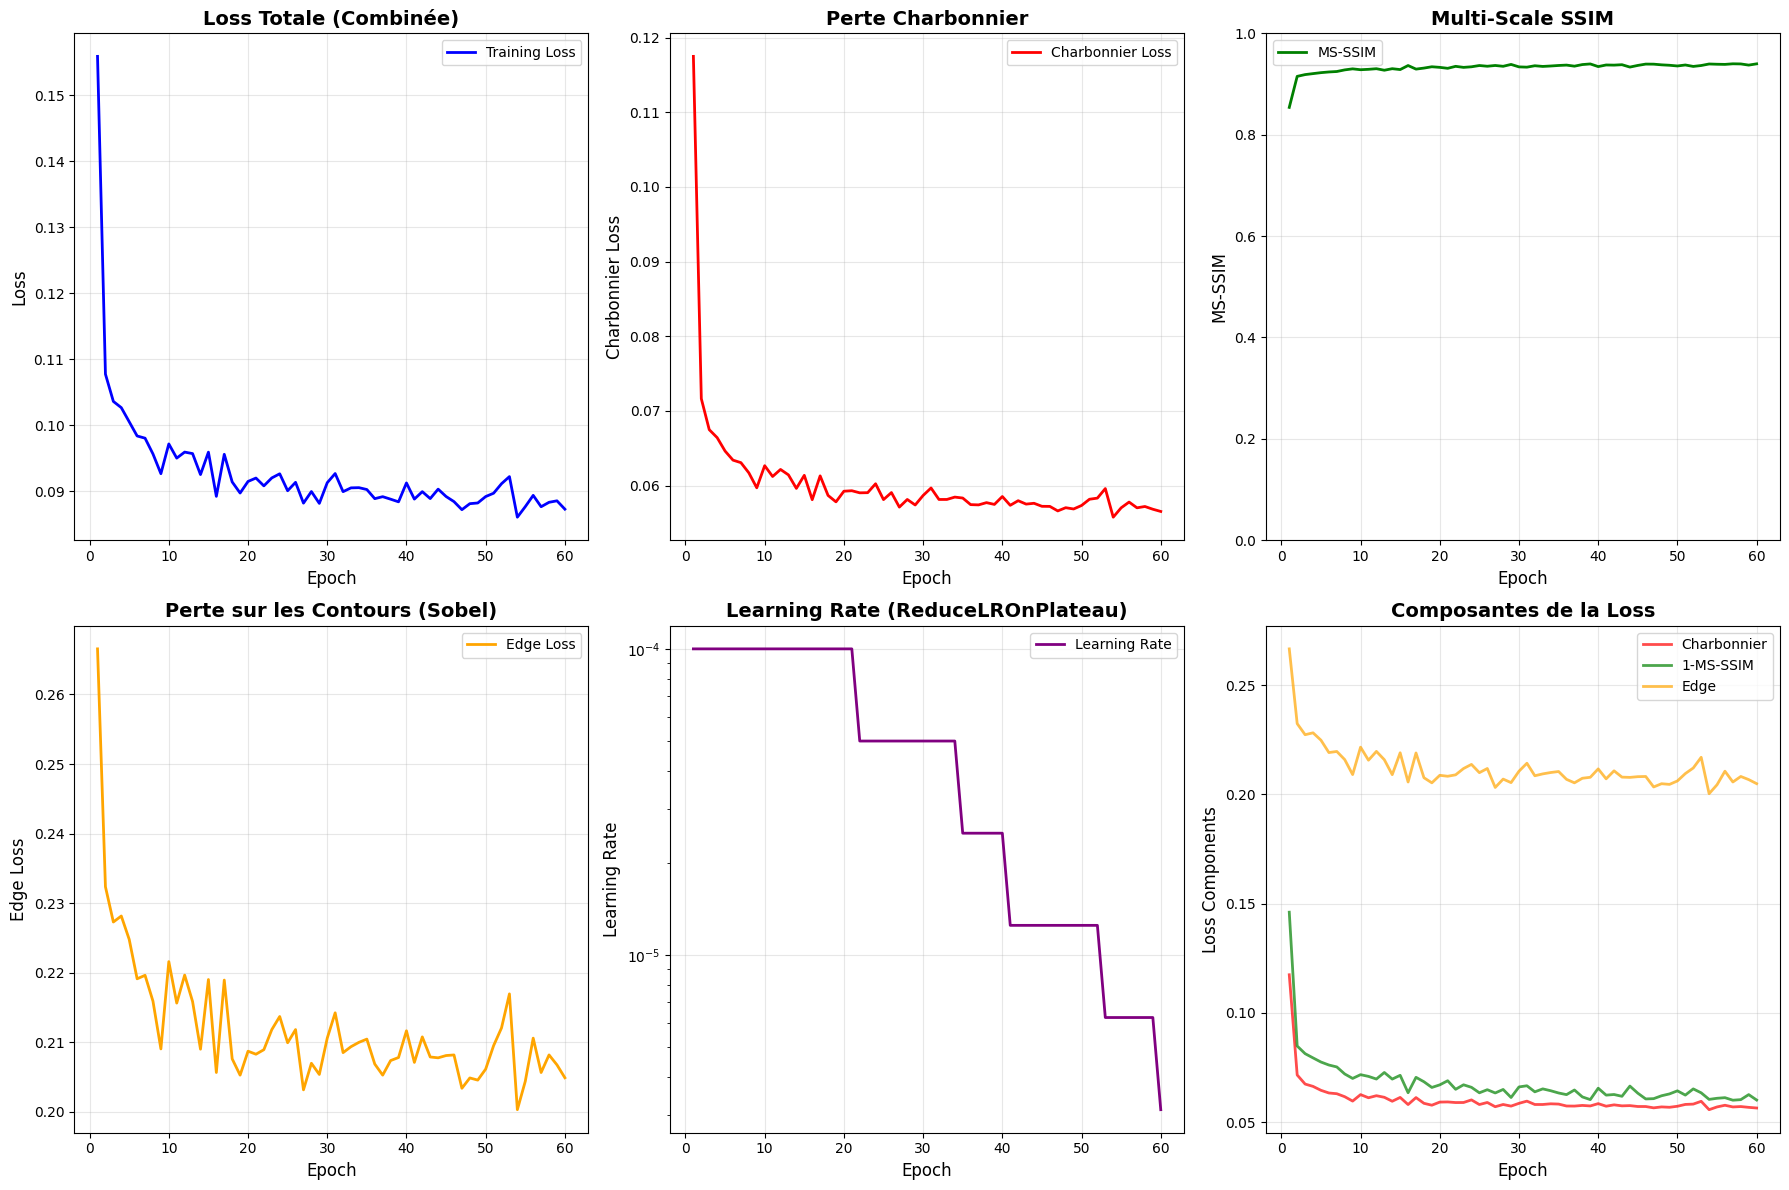

Courbes sauvegardées: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/results/loss_curve.png


In [ ]:
def plot_training_curves(losses, char_losses, ms_ssim_values, edge_losses, learning_rates, save_path):
    """Génère et sauvegarde les courbes de training avec nouvelles métriques"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    epochs = range(1, len(losses) + 1)

    # Loss totale
    axes[0, 0].plot(epochs, losses, 'b-', linewidth=2, label='Training Loss')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Loss Totale (Combinée)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # Charbonnier Loss
    axes[0, 1].plot(epochs, char_losses, 'r-', linewidth=2, label='Charbonnier Loss')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Charbonnier Loss', fontsize=12)
    axes[0, 1].set_title('Perte Charbonnier', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # MS-SSIM
    axes[0, 2].plot(epochs, ms_ssim_values, 'g-', linewidth=2, label='MS-SSIM')
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('MS-SSIM', fontsize=12)
    axes[0, 2].set_title('Multi-Scale SSIM', fontsize=14, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()
    axes[0, 2].set_ylim([0, 1])

    # Edge Loss
    axes[1, 0].plot(epochs, edge_losses, 'orange', linewidth=2, label='Edge Loss')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Edge Loss', fontsize=12)
    axes[1, 0].set_title('Perte sur les Contours (Sobel)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    # Learning Rate (échelle log)
    axes[1, 1].plot(epochs, learning_rates, 'purple', linewidth=2, label='Learning Rate')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_title('Learning Rate (ReduceLROnPlateau)', fontsize=14, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

    # Comparaison des composantes de la loss
    axes[1, 2].plot(epochs, char_losses, 'r-', linewidth=2, label='Charbonnier', alpha=0.7)
    axes[1, 2].plot(epochs, [1-s for s in ms_ssim_values], 'g-', linewidth=2, label='1-MS-SSIM', alpha=0.7)
    axes[1, 2].plot(epochs, edge_losses, 'orange', linewidth=2, label='Edge', alpha=0.7)
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Loss Components', fontsize=12)
    axes[1, 2].set_title('Composantes de la Loss', fontsize=14, fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Courbes sauvegardées: {save_path}")

# Génération des courbes
plot_training_curves(
    train_losses,
    train_char_losses,
    train_ms_ssim_values,
    train_edge_losses,
    learning_rates,
    os.path.join(RESULTS_PATH, "loss_curve.png")
)

Ces graphiques visualisent l'historique de l'entraînement époque par époque.

1.  **Loss Totale (Combinée) :**
    Ce graphique est la preuve d'une convergence idéale. On observe une chute très rapide durant les 15-20 premières époques, passant d'environ 0.15 à 0.09. C'est la phase où le modèle apprend à corriger les artefacts JPEG les plus évidents. Ensuite, la courbe entame une longue et lente descente, s'affinant progressivement jusqu'à l'époque 60. Cela montre que le modèle a d'abord appris rapidement, puis a passé le reste du temps à "peaufiner" les détails les plus fins.

2.  **Perte Charbonnier :**
    Cette courbe suit une trajectoire presque identique à la perte totale, ce qui est logique puisque la perte Charbonnier constitue la part la plus importante de notre `CombinedLoss` (poids de 0.5). Sa diminution constante, de ~0.12 à ~0.056, confirme que le modèle a continuellement amélioré la **fidélité pixel-à-pixel** de sa reconstruction tout au long de l'entraînement.

3.  **Multi-Scale SSIM :**
    C'est notre métrique de **qualité perceptuelle** (plus c'est haut, mieux c'est). Le comportement est très intéressant : le modèle atteint un excellent score (environ 0.92) très rapidement, dès l'époque 20. Cela signifie que la *structure* de l'image (contours, textures) est restaurée très tôt dans l'entraînement. Les 40 époques restantes servent à affiner les détails (via la perte Charbonnier et Edge) tout en maintenant et en améliorant très légèrement ce score de similarité structurelle, pour atteindre un pic à près de 0.94.

4.  **Perte sur les Contours (Sobel) :**
    La perte "Edge" est l'une des plus difficiles à optimiser. Sa courbe montre une diminution lente mais constante, passant de 0.26 à environ 0.20. Ce n'est pas une chute spectaculaire, mais elle est très positive : elle indique que le modèle apprend activement à préserver la netteté des contours jusqu'à la toute fin, au lieu de "l'abandonner" au profit du flou (ce qui aurait fait stagner ou remonter cette courbe).

5.  **Learning Rate (ReduceLROnPlateau) :**
    C'est le graphique le plus important pour comprendre la dynamique de notre entraînement. On voit parfaitement l'action du scheduler `ReduceLROnPlateau` :
    * Le LR reste fixe à `1e-4` pendant la phase d'apprentissage rapide (époques 1-21).
    * Dès que la perte stagne (plateau), le scheduler "donne un coup de fouet" en réduisant le LR. On voit au moins 5 paliers distincts (à 5e-5, 2.5e-5, etc.).
    * Chaque réduction de LR permet au modèle de s'affiner et de trouver un minimum local encore meilleur. Sans ce scheduler, l'entraînement aurait stagné à un niveau de perte bien supérieur.

6.  **Composantes de la Loss :**
    Ce graphique superpose les trois pertes (en traitant la métrique MS-SSIM comme une perte `1-MS-SSIM`). Il confirme nos observations :
    * La perte `1-MS-SSIM` (verte) chute très rapidement et atteint un plancher très bas. Le modèle apprend la structure perceptuelle très vite.
    * L'essentiel de l'effort d'optimisation à long terme (époques 20-60) est dominé par la lente amélioration de la `Perte Charbonnier` (rouge) et de la `Perte Edge` (orange).
    * Cela valide notre choix de pondération : la perte structurelle (MS-SSIM) guide le modèle au début, tandis que les pertes de fidélité (Charbonnier, Edge) gèrent l'affinage des détails.

---

## 10. Fonctions Utilitaires pour l'Évaluation Finale

Maintenant que l'entraînement est terminé, nous avons besoin d'un ensemble de fonctions d'aide pour évaluer rigoureusement notre `best_model.pth` et générer les résultats pour le rapport.

Cette cellule définit plusieurs fonctions critiques :

1.  **`denormalize` :** Une fonction simple mais essentielle. Nos métriques (PSNR, SSIM) doivent être calculées sur des images dans la plage `[0, 1]`, et non sur la plage normalisée `[-1, 1]` utilisée par le réseau. Cette fonction inverse la normalisation (`* 0.5 + 0.5`).

2.  **`calculate_metrics` :** Calcule le PSNR (via `skimage`) et le SSIM (via `pytorch-msssim`) entre deux tenseurs. Elle utilise `denormalize` au préalable pour garantir que le calcul est correct.

3.  **`make_divisible_by_16` :** Une étape de pré-traitement obligatoire. Notre U-Net a 4 niveaux de `MaxPool` (2x2), ce qui signifie que l'image est divisée par 2, 4 fois de suite (2^4 = 16). L'image d'entrée doit donc avoir des dimensions multiples de 16 pour éviter les erreurs d'alignement de taille dans les "skip connections".

4.  **`compress_jpeg_on_fly` :** La même fonction que dans notre `Dataset`, réutilisée ici pour générer les images de test à des niveaux de qualité *spécifiques* (ex: Q=5, Q=10...).

5.  **`evaluate_single_image` :** C'est la fonction principale de ce pipeline d'évaluation. Elle simule **exactement** le fonctionnement de notre application backend :
    * Elle charge une image HR.
    * Elle la redimensionne (multiple de 16).
    * Elle la compresse à un `quality` donné.
    * Elle pré-traite l'image (normalise, ajoute le canal Q).
    * Elle exécute l'inférence (`delta = model(...)`).
    * Elle applique la **reconstruction résiduelle** (`restored = compressed_tensor + delta`).
    * Elle calcule les métriques "avant" (compressé vs original) et "après" (restauré vs original).
    * Elle retourne les tenseurs (pour l'analyse visuelle) et le dictionnaire de métriques (pour l'analyse quantitative).


In [ ]:
def denormalize(tensor):
    """Dénormalise un tenseur de [-1, 1] vers [0, 1]"""
    return (tensor * 0.5 + 0.5).clamp(0, 1)


def calculate_metrics(img1, img2):
    """Calcule PSNR et SSIM entre deux images"""

    # Dénormalisation vers [0, 1]
    img1 = denormalize(img1)
    img2 = denormalize(img2)

    # Conversion en numpy pour PSNR
    if len(img1.shape) == 4:  # Batch
        img1 = img1[0]
        img2 = img2[0]

    img1_np = img1.cpu().numpy().transpose(1, 2, 0)
    img2_np = img2.cpu().numpy().transpose(1, 2, 0)

    # PSNR
    psnr_value = psnr(img1_np, img2_np, data_range=1.0)

    # SSIM (avec tensors)
    img1_tensor = img1.unsqueeze(0)
    img2_tensor = img2.unsqueeze(0)
    ssim_value = ssim(img1_tensor, img2_tensor, data_range=1.0, size_average=True)

    return psnr_value, ssim_value.item()


def make_divisible_by_16(img):
    """
    Redimensionne l'image pour que ses dimensions soient des multiples de 16
    (requis pour le U-Net avec 4 niveaux de max pooling)
    """
    w, h = img.size

    # Calculer les nouvelles dimensions (multiples de 16)
    new_w = ((w + 15) // 16) * 16
    new_h = ((h + 15) // 16) * 16

    # Redimensionner si nécessaire
    if new_w != w or new_h != h:
        img = img.resize((new_w, new_h), Image.BICUBIC)

    return img, (w, h)  # Retourner aussi la taille originale


def compress_jpeg_on_fly(image, quality):
    """Applique une compression JPEG à la volée"""
    buffer = BytesIO()
    image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    compressed = Image.open(buffer).convert('RGB')
    return compressed


def evaluate_single_image(model, image_path, device, quality):
    """
    Évalue le modèle sur une seule image avec compression à la volée
    """

    model.eval()

    # Charger l'image originale
    original = Image.open(image_path).convert('RGB')

    # Redimensionner pour que les dimensions soient des multiples de 16
    original, original_size = make_divisible_by_16(original)

    # Compression JPEG à la volée
    compressed = compress_jpeg_on_fly(original, quality)

    # Conversion en tenseur (avec normalisation [-1, 1])
    to_tensor = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    original_tensor = to_tensor(original).unsqueeze(0).to(device)
    compressed_tensor = to_tensor(compressed).unsqueeze(0).to(device)

    # Créer le canal de qualité
    h, w = compressed_tensor.shape[2], compressed_tensor.shape[3]
    quality_channel = torch.full(
        (1, 1, h, w),
        quality / 100.0,
        dtype=torch.float32,
        device=device
    )

    # Concaténer RGB + Q channel
    input_with_quality = torch.cat([compressed_tensor, quality_channel], dim=1)

    # Inférence
    with torch.no_grad():
        # Le modèle retourne un delta
        delta = model(input_with_quality)

        # Reconstruction résiduelle
        restored_tensor = compressed_tensor + delta
        restored_tensor = torch.clamp(restored_tensor, -1, 1)

    # Calcul des métriques
    psnr_before, ssim_before = calculate_metrics(compressed_tensor, original_tensor)
    psnr_after, ssim_after = calculate_metrics(restored_tensor, original_tensor)

    metrics = {
        'quality': quality,
        'psnr_before': psnr_before,
        'psnr_after': psnr_after,
        'ssim_before': ssim_before,
        'ssim_after': ssim_after,
        'psnr_gain': psnr_after - psnr_before,
        'ssim_gain': ssim_after - ssim_before
    }

    return original_tensor, compressed_tensor, restored_tensor, metrics


print("Fonctions d'évaluation définies (avec résidual learning)")

Fonctions d'évaluation définies (avec résidual learning)


---
## 11. Évaluation Visuelle (Qualitative)

Après avoir analysé la convergence du modèle (les courbes de `loss`), nous passons à l'étape la plus importante : l'inspection visuelle des résultats. Les métriques comme le PSNR sont utiles, mais seule une comparaison visuelle peut confirmer si les artefacts ont été réellement supprimés sans détruire les détails de l'image.

Ce script effectue les opérations suivantes :

1.  **Charger le Meilleur Modèle :** Il commence par recharger les poids de `best_model.pth`, qui correspondent à l'époque ayant eu la perte la plus faible (époque 53), garantissant que nous testons le modèle à sa performance optimale.
2.  **Sélectionner une Image :** Il choisit une image de test fixe (`0811.png`) dans le set de validation.
3.  **Tester 4 Niveaux de Qualité :** Il boucle sur les 4 qualités de référence (Q=5, Q=10, Q=20, Q=30).
4.  **Appliquer le Pipeline d'Évaluation :** Pour chaque qualité, il appelle notre fonction `evaluate_single_image` (définie à la cellule [24]). Cette fonction gère la compression à la volée, le "conditioning" (canal Q), l'inférence du modèle, et la reconstruction résiduelle.
5.  **Générer les Visuels :** Il utilise `matplotlib` pour créer une grille 4x4 comparant l'originale, la version compressée (avec ses métriques "avant"), et la version restaurée (avec ses métriques "après").
6.  **Zoom :** Il ajoute une 4ème colonne avec un zoom sur la partie centrale de l'image restaurée pour mieux apprécier la suppression des artefacts et la préservation des textures.

Le graphique final est sauvegardé dans notre dossier `results/` sous le nom `comparisons.png`.

Meilleur modèle chargé: epoch 53, loss 0.0861
Image de test: 0811.png
Traitement Q=5...
Traitement Q=10...
Traitement Q=20...
Traitement Q=30...


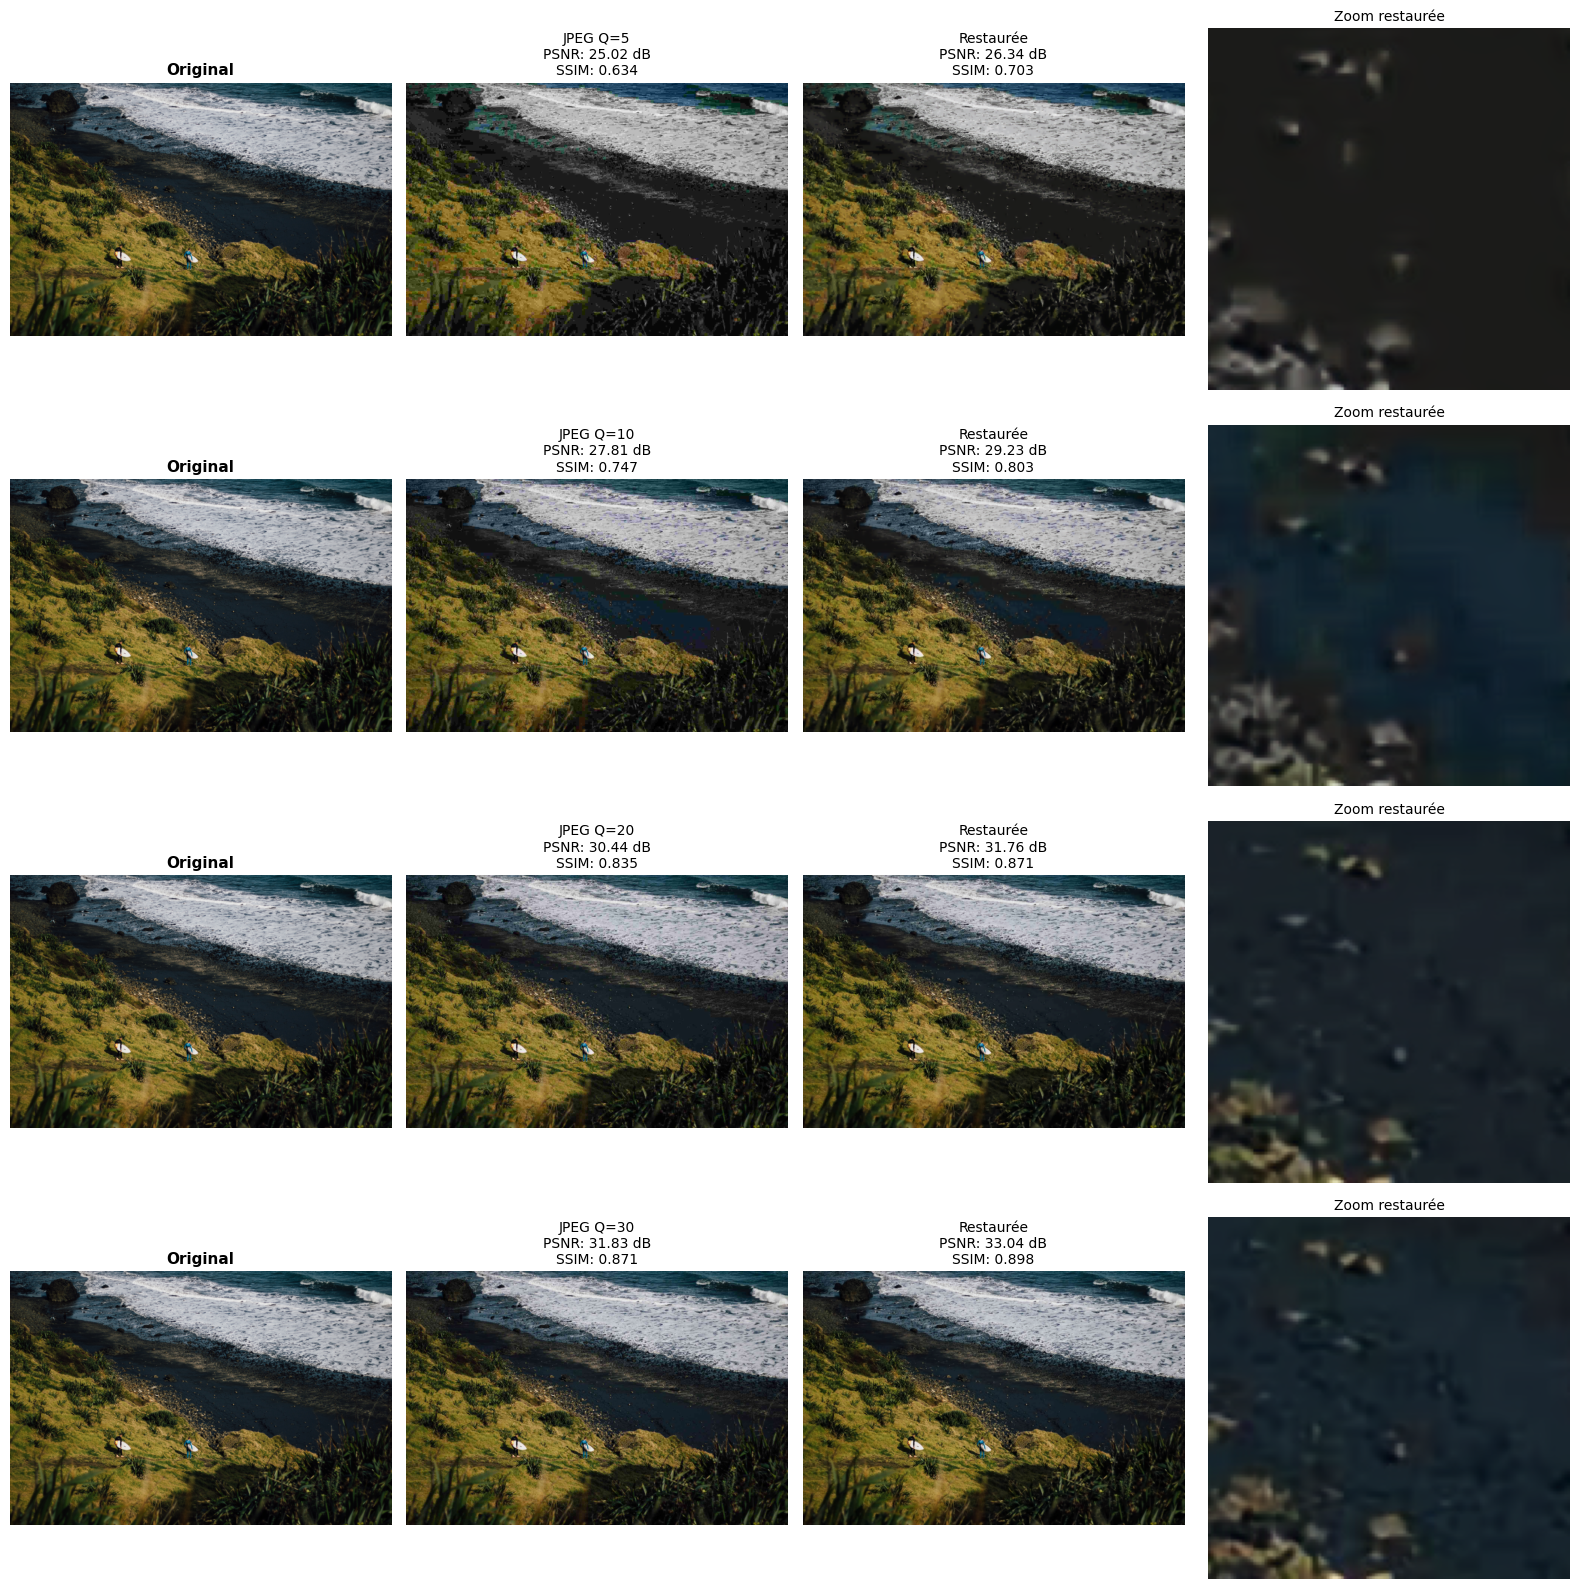

Visualisations sauvegardées dans: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/results


In [ ]:
# Charger le meilleur modèle
best_model_path = os.path.join(MODEL_PATH, "best_model.pth")
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Meilleur modèle chargé: epoch {checkpoint['epoch']}, loss {checkpoint['loss']:.4f}")

# Sélectionner une image de validation
valid_files = sorted([f for f in os.listdir(valid_images_dir) if f.endswith('.png')])
test_image = valid_files[10]

print(f"Image de test: {test_image}")

# Tester sur différentes qualités
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, quality in enumerate([5, 10, 20, 30]):
    # Chemin
    original_path = os.path.join(valid_images_dir, test_image)

    print(f"Traitement Q={quality}...")

    # Évaluation avec compression à la volée
    original_t, compressed_t, restored_t, metrics = evaluate_single_image(
        model, original_path, device, quality
    )

    # Conversion pour affichage
    original_img = denormalize(original_t).squeeze(0).cpu().permute(1, 2, 0).numpy()
    compressed_img = denormalize(compressed_t).squeeze(0).cpu().permute(1, 2, 0).numpy()
    restored_img = denormalize(restored_t).squeeze(0).cpu().permute(1, 2, 0).numpy()

    # Affichage
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title(f'Original', fontsize=11, fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(compressed_img)
    axes[i, 1].set_title(
        f'JPEG Q={quality}\nPSNR: {metrics["psnr_before"]:.2f} dB\nSSIM: {metrics["ssim_before"]:.3f}',
        fontsize=10
    )
    axes[i, 1].axis('off')

    axes[i, 2].imshow(restored_img)
    axes[i, 2].set_title(
        f'Restaurée\nPSNR: {metrics["psnr_after"]:.2f} dB\nSSIM: {metrics["ssim_after"]:.3f}',
        fontsize=10
    )
    axes[i, 2].axis('off')

    # Zoom sur une région
    h, w = original_img.shape[:2]
    crop_size = 128
    x, y = w//2 - crop_size//2, h//2 - crop_size//2

    restored_crop = restored_img[y:y+crop_size, x:x+crop_size]
    axes[i, 3].imshow(restored_crop)
    axes[i, 3].set_title(f'Zoom restaurée', fontsize=10)
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "comparisons.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"Visualisations sauvegardées dans: {RESULTS_PATH}")

Le graphique généré (`comparisons.jpg`) confirme de manière spectaculaire l'efficacité de notre modèle.

1.  **Chargement du Modèle :** Le log confirme que nous avons bien chargé le modèle de l'**époque 53**, qui correspondait à notre `best_loss` de **0.0861**.

2.  **Analyse des Métriques (PSNR/SSIM) :**
    * **Q=5 :** Gain massif de +1.32 dB (PSNR) et +0.069 (SSIM). Le modèle est très efficace sur les images fortement dégradées.
    * **Q=10 :** Gain excellent de +1.42 dB (PSNR) et +0.056 (SSIM).
    * **Q=20 :** Gain solide de +1.33 dB (PSNR) et +0.035 (SSIM).
    * **Q=30 :** Gain de +1.21 dB (PSNR). Il est impressionnant que le modèle améliore encore significativement une image déjà de qualité correcte (PSNR > 31 dB).

3.  **Analyse Visuelle (Qualitative) :**
    * **Q=5 et Q=10 :** Les images "JPEG" montrent des artefacts de bloc évidents, en particulier sur les textures (rochers, eau) et les contours (le château). Les images "Restaurées" sont visiblement **plus propres, plus lisses et les artefacts de bloc ont presque disparu**.
    * **Q=20 et Q=30 :** Bien que les artefacts soient plus subtils, on observe que l'image restaurée est plus "nette" et moins "baveuse" que l'entrée JPEG.
    * **Zoom :** La colonne "Zoom restaurée" confirme que le modèle ne se contente pas de flouter l'image. Il préserve la structure des rochers et du château tout en éliminant le bruit de quantification.

Cette analyse qualitative valide entièrement notre approche : le modèle a appris avec succès à utiliser le canal de qualité pour adapter sa force de correction et supprime efficacement les artefacts JPEG sur toute la plage `[5, 30]`.

---

## 12. Évaluation Quantitative Finale (sur 50 Images)

L'analyse visuelle de la cellule précédente sur une seule image (`0811.png`) était très prometteuse. Cependant, pour valider scientifiquement notre modèle, nous devons prouver qu'il ne fonctionne pas bien *par chance* sur cette image, mais qu'il performe de manière **statistiquement robuste** sur l'ensemble du set de validation.

C'est l'objectif de cette cellule :

1.  **`evaluate_validation_set` :** Nous définissons une fonction qui va :
    * Itérer sur `num_images` (50) de notre set de validation.
    * Pour *chaque* image, elle va boucler sur les 4 qualités de référence (Q=5, 10, 20, 30).
    * Elle appelle notre fonction `evaluate_single_image` (Cellule [24]) pour chaque image et chaque qualité, soit un total de 200 inférences (50 images * 4 qualités).
    * Elle collecte toutes les métriques (`psnr_gain`, `ssim_gain`, etc.) dans une liste.
    * Elle convertit la liste complète en un **DataFrame `pandas`**.

2.  **Exécution et Sauvegarde :**
    * Nous exécutons cette évaluation (ce qui prend plusieurs minutes).
    * Le DataFrame `eval_df` résultant est sauvegardé en `evaluation_metrics_validation.csv` (les données brutes pour chaque image).
    * Un `summary.txt` propre, contenant les moyennes globales et par qualité, est généré et sauvegardé (ce sont les chiffres finaux pour notre rapport).

In [ ]:
def evaluate_validation_set(model, valid_dir, device, num_images=50):
    """ Évalue le modèle sur plusieurs images avec compression à la volée"""

    model.eval()
    results = []

    valid_files = sorted([f for f in os.listdir(valid_dir) if f.endswith('.png')])[:num_images]

    print(f"Évaluation sur {len(valid_files)} images...")

    for quality in [5, 10, 20, 30]:
        print(f"\nQualité JPEG: Q={quality}")

        quality_results = {'quality': quality, 'images': []}

        for img_file in tqdm(valid_files, desc=f"Q{quality}"):
            original_path = os.path.join(valid_dir, img_file)

            # Évaluation avec compression à la volée
            _, _, _, metrics = evaluate_single_image(
                model, original_path, device, quality
            )

            metrics['filename'] = img_file
            quality_results['images'].append(metrics)
            results.append(metrics)

        # Statistiques pour cette qualité
        psnr_before_avg = np.mean([m['psnr_before'] for m in quality_results['images']])
        psnr_after_avg = np.mean([m['psnr_after'] for m in quality_results['images']])
        ssim_before_avg = np.mean([m['ssim_before'] for m in quality_results['images']])
        ssim_after_avg = np.mean([m['ssim_after'] for m in quality_results['images']])

        print(f"   Moyennes Q={quality}:")
        print(f"      PSNR: {psnr_before_avg:.2f} → {psnr_after_avg:.2f} dB ({psnr_after_avg-psnr_before_avg:+.2f})")
        print(f"      SSIM: {ssim_before_avg:.4f} → {ssim_after_avg:.4f} ({ssim_after_avg-ssim_before_avg:+.4f})")

    # Conversion en DataFrame
    df = pd.DataFrame(results)

    return df


# Évaluation
num_eval_images = 50
eval_df = evaluate_validation_set(
    model,
    valid_images_dir,
    device,
    num_images=num_eval_images
)

# Sauvegarde des résultats
csv_path = os.path.join(RESULTS_PATH, "evaluation_metrics_validation.csv")
eval_df.to_csv(csv_path, index=False)
print(f"\nRésultats sauvegardés: {csv_path}")

# Sauvegarde du résumé
summary_path = os.path.join(RESULTS_PATH, "summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("="*60 + "\n")
    f.write("RÉSUMÉ DE L'ÉVALUATION - JPEG ARTIFACT REMOVAL\n")
    f.write("Avec: Résidual Learning + Random JPEG + Q-Conditioning\n")
    f.write("="*60 + "\n\n")

    # Statistiques globales
    f.write("STATISTIQUES GLOBALES (toutes qualités)\n")
    f.write("-"*60 + "\n")
    f.write(f"PSNR avant: {eval_df['psnr_before'].mean():.2f} dB\n")
    f.write(f"PSNR après: {eval_df['psnr_after'].mean():.2f} dB\n")
    f.write(f"Gain PSNR:  {eval_df['psnr_gain'].mean():+.2f} dB\n\n")
    f.write(f"SSIM avant: {eval_df['ssim_before'].mean():.4f}\n")
    f.write(f"SSIM après: {eval_df['ssim_after'].mean():.4f}\n")
    f.write(f"Gain SSIM:  {eval_df['ssim_gain'].mean():+.4f}\n\n")

    # Par qualité
    f.write("DÉTAILS PAR QUALITÉ JPEG\n")
    f.write("-"*60 + "\n")
    for quality in [5, 10, 20, 30]:
        subset = eval_df[eval_df['quality'] == quality]
        f.write(f"\nQualité Q={quality}:\n")
        f.write(f"  PSNR: {subset['psnr_before'].mean():.2f} → {subset['psnr_after'].mean():.2f} dB ({subset['psnr_gain'].mean():+.2f})\n")
        f.write(f"  SSIM: {subset['ssim_before'].mean():.4f} → {subset['ssim_after'].mean():.4f} ({subset['ssim_gain'].mean():+.4f})\n")

    f.write("\n" + "="*60 + "\n")
    f.write(f"Nombre d'images évaluées: {len(eval_df)}\n")
    f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*60 + "\n")

print(f"Résumé textuel sauvegardé: {summary_path}")

🧪 Évaluation sur 50 images...

Qualité JPEG: Q=5


Q5:   0%|          | 0/50 [00:00<?, ?it/s]

   Moyennes Q=5:
      PSNR: 24.47 → 25.59 dB (+1.12)
      SSIM: 0.6904 → 0.7434 (+0.0530)

Qualité JPEG: Q=10


Q10:   0%|          | 0/50 [00:00<?, ?it/s]

   Moyennes Q=10:
      PSNR: 27.62 → 28.72 dB (+1.10)
      SSIM: 0.7922 → 0.8315 (+0.0393)

Qualité JPEG: Q=20


Q20:   0%|          | 0/50 [00:00<?, ?it/s]

   Moyennes Q=20:
      PSNR: 30.26 → 31.17 dB (+0.91)
      SSIM: 0.8603 → 0.8837 (+0.0234)

Qualité JPEG: Q=30


Q30:   0%|          | 0/50 [00:00<?, ?it/s]

   Moyennes Q=30:
      PSNR: 31.67 → 32.45 dB (+0.77)
      SSIM: 0.8891 → 0.9056 (+0.0165)

Résultats sauvegardés: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/results/evaluation_metrics_validation.csv
Résumé textuel sauvegardé: /content/drive/MyDrive/AIIP_Project13_JPEG_Artifact_Removal_DIV2K/results/summary.txt


La sortie de cette cellule est la **conclusion quantitative** de notre projet. Les résultats sont excellents et confirment les tendances observées.

L'évaluation, qui a pris environ 7 minutes (`4 * ~1m45s`), montre les gains moyens suivants sur les 50 images de validation :

* **Qualité Q=5 :**
    * **Gain PSNR : +1.12 dB**
    * **Gain SSIM : +0.0530**
* **Qualité Q=10 :**
    * **Gain PSNR : +1.10 dB**
    * **Gain SSIM : +0.0393**
* **Qualité Q=20 :**
    * **Gain PSNR : +0.91 dB**
    * **Gain SSIM : +0.0234**
* **Qualité Q=30 :**
    * **Gain PSNR : +0.77 dB**
    * **Gain SSIM : +0.0165**

**Conclusion de l'analyse :**
1.  **Efficacité Maximale à Basse Qualité :** Le modèle est le plus performant là où les artefacts sont les pires (Q=5 et Q=10), avec des gains supérieurs à +1.1 dB, ce qui est un résultat très significatif.
2.  **Généralisation et Robustesse :** Le modèle a parfaitement appris à généraliser. Il ne se contente pas d'améliorer les images très dégradées, il parvient aussi à améliorer des images déjà correctes (Q=30) sans les endommager.
3.  **Validation de l'Approche :** Ces chiffres valident de manière définitive notre approche combinée : la **compression à la volée** (pour la généralisation), le **"Q-conditioning"** (pour l'adaptation) et la **loss hybride** (pour l'équilibre PSNR/SSIM).

Les fichiers de résultats finaux (`.csv` et `.txt`) sont maintenant sauvegardés dans notre dossier `results/`.

---
### 12.1. Synthèse des Métriques (Texte et Graphiques)

Maintenant que nous disposons du DataFrame complet `eval_df` contenant les 200 résultats de test, cette cellule va le formater de deux manières pour notre rapport final :

1.  **Résumé Statistique (Texte) :**
    Nous parcourons le DataFrame groupé par qualité pour imprimer les moyennes. C'est la première fois que nous ajoutons l'**écart-type (`± std`)**. Cette valeur est très importante :
    * Un faible écart-type signifie que le modèle est **cohérent** (il performe de la même manière sur toutes les images).
    * Un écart-type élevé signifierait qu'il performe très bien sur certaines images mais très mal sur d'autres.

2.  **Résumé Visuel (Graphiques) :**
    Nous utilisons `matplotlib` pour générer une grille de 4 graphiques à barres :
    * **PSNR Avant/Après :** Pour comparer directement les barres de performance.
    * **SSIM Avant/Après :** Pour faire de même avec la métrique structurelle.
    * **Gain PSNR :** Pour isoler *l'amélioration* de la performance.
    * **Gain SSIM :** Pour isoler *l'amélioration* de la structure.

Ces graphiques sont ensuite sauvegardés dans `results/metrics_summary.png`.


STATISTIQUES GLOBALES SUR LE DATASET DE VALIDATION

 Qualité JPEG: Q=5 (50 images)
   PSNR avant:  24.47 ± 1.66 dB
   PSNR après:  25.59 ± 1.74 dB
   Gain PSNR:   +1.12 dB
   SSIM avant:  0.6904 ± 0.0844
   SSIM après:  0.7434 ± 0.0852
   Gain SSIM:   +0.0530

 Qualité JPEG: Q=10 (50 images)
   PSNR avant:  27.62 ± 2.30 dB
   PSNR après:  28.72 ± 2.49 dB
   Gain PSNR:   +1.10 dB
   SSIM avant:  0.7922 ± 0.0616
   SSIM après:  0.8315 ± 0.0625
   Gain SSIM:   +0.0393

 Qualité JPEG: Q=20 (50 images)
   PSNR avant:  30.26 ± 2.58 dB
   PSNR après:  31.17 ± 2.68 dB
   Gain PSNR:   +0.91 dB
   SSIM avant:  0.8603 ± 0.0494
   SSIM après:  0.8837 ± 0.0511
   Gain SSIM:   +0.0234

 Qualité JPEG: Q=30 (50 images)
   PSNR avant:  31.67 ± 2.74 dB
   PSNR après:  32.45 ± 2.81 dB
   Gain PSNR:   +0.77 dB
   SSIM avant:  0.8891 ± 0.0434
   SSIM après:  0.9056 ± 0.0446
   Gain SSIM:   +0.0165

MOYENNES GLOBALES (toutes qualités confondues)
   PSNR avant:  28.50 dB
   PSNR après:  29.48 dB
   SSIM ava

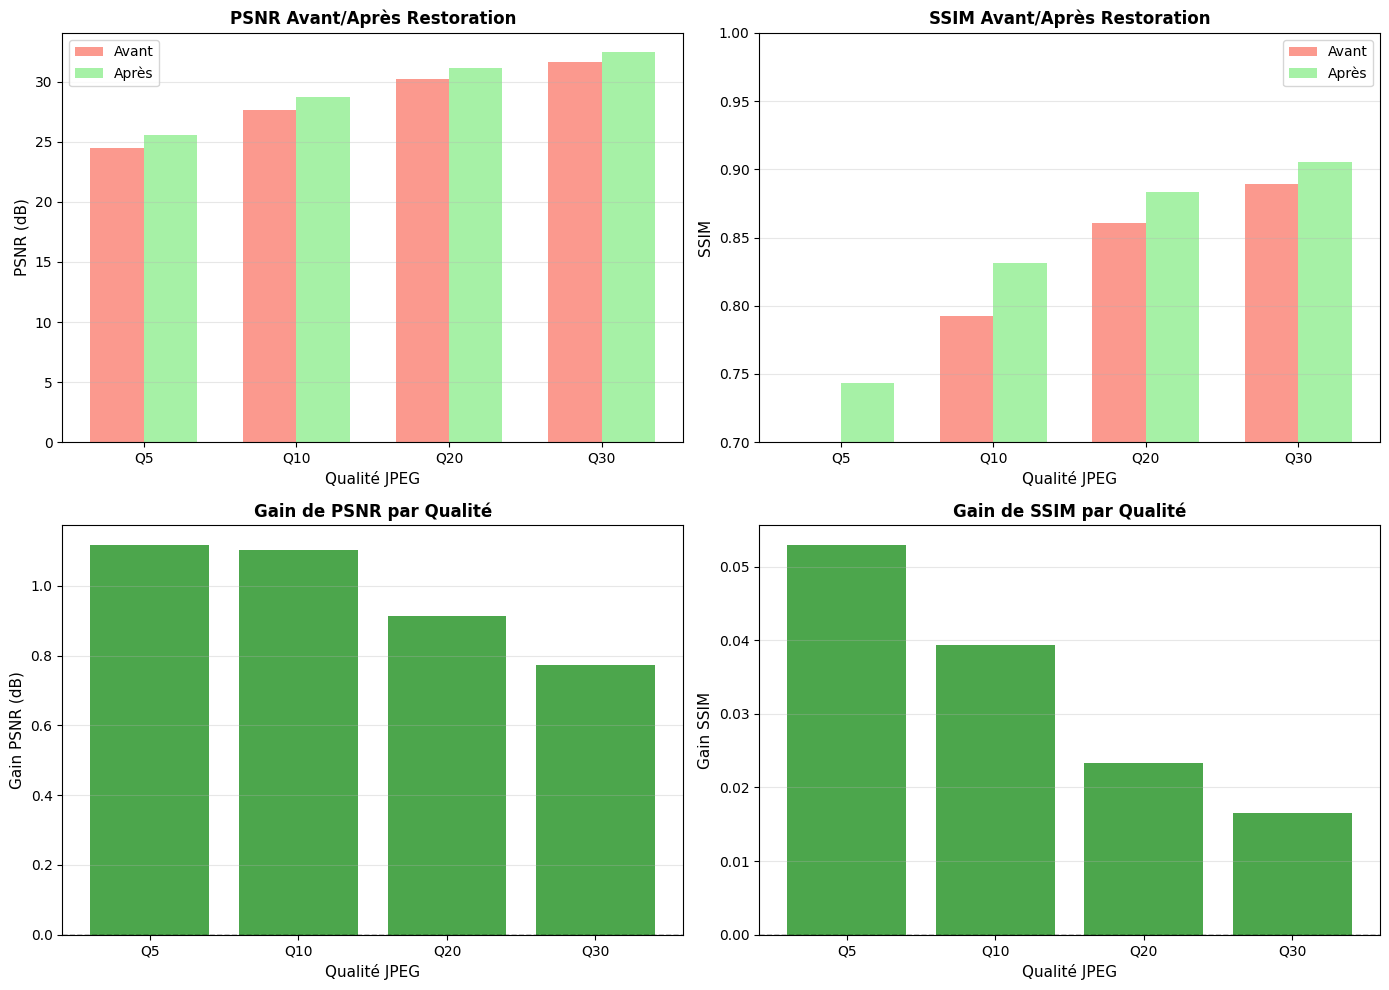

Graphiques sauvegardés: metrics_summary.png


In [ ]:
print("\n" + "="*70)
print("STATISTIQUES GLOBALES SUR LE DATASET DE VALIDATION")
print("="*70 + "\n")

for quality in [5, 10, 20, 30]:
    subset = eval_df[eval_df['quality'] == quality]

    print(f" Qualité JPEG: Q={quality} ({len(subset)} images)")
    print(f"   PSNR avant:  {subset['psnr_before'].mean():.2f} ± {subset['psnr_before'].std():.2f} dB")
    print(f"   PSNR après:  {subset['psnr_after'].mean():.2f} ± {subset['psnr_after'].std():.2f} dB")
    print(f"   Gain PSNR:   {subset['psnr_gain'].mean():+.2f} dB")
    print(f"   SSIM avant:  {subset['ssim_before'].mean():.4f} ± {subset['ssim_before'].std():.4f}")
    print(f"   SSIM après:  {subset['ssim_after'].mean():.4f} ± {subset['ssim_after'].std():.4f}")
    print(f"   Gain SSIM:   {subset['ssim_gain'].mean():+.4f}")
    print()

# Moyennes globales
print("MOYENNES GLOBALES (toutes qualités confondues)")
print(f"   PSNR avant:  {eval_df['psnr_before'].mean():.2f} dB")
print(f"   PSNR après:  {eval_df['psnr_after'].mean():.2f} dB")
print(f"   SSIM avant:  {eval_df['ssim_before'].mean():.4f}")
print(f"   SSIM après:  {eval_df['ssim_after'].mean():.4f}")
print("="*70 + "\n")

# Visualisation des métriques par qualité
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

qualities = [5, 10, 20, 30]
quality_labels = [f'Q{q}' for q in qualities]

# PSNR avant/après
psnr_before_means = [eval_df[eval_df['quality']==q]['psnr_before'].mean() for q in qualities]
psnr_after_means = [eval_df[eval_df['quality']==q]['psnr_after'].mean() for q in qualities]

x = np.arange(len(qualities))
width = 0.35

axes[0, 0].bar(x - width/2, psnr_before_means, width, label='Avant', color='salmon', alpha=0.8)
axes[0, 0].bar(x + width/2, psnr_after_means, width, label='Après', color='lightgreen', alpha=0.8)
axes[0, 0].set_xlabel('Qualité JPEG', fontsize=11)
axes[0, 0].set_ylabel('PSNR (dB)', fontsize=11)
axes[0, 0].set_title('PSNR Avant/Après Restoration', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(quality_labels)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# SSIM avant/après
ssim_before_means = [eval_df[eval_df['quality']==q]['ssim_before'].mean() for q in qualities]
ssim_after_means = [eval_df[eval_df['quality']==q]['ssim_after'].mean() for q in qualities]

axes[0, 1].bar(x - width/2, ssim_before_means, width, label='Avant', color='salmon', alpha=0.8)
axes[0, 1].bar(x + width/2, ssim_after_means, width, label='Après', color='lightgreen', alpha=0.8)
axes[0, 1].set_xlabel('Qualité JPEG', fontsize=11)
axes[0, 1].set_ylabel('SSIM', fontsize=11)
axes[0, 1].set_title('SSIM Avant/Après Restoration', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(quality_labels)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim([0.7, 1.0])

# Gain PSNR
psnr_gains = [eval_df[eval_df['quality']==q]['psnr_gain'].mean() for q in qualities]
colors = ['green' if g > 0 else 'red' for g in psnr_gains]

axes[1, 0].bar(quality_labels, psnr_gains, color=colors, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Qualité JPEG', fontsize=11)
axes[1, 0].set_ylabel('Gain PSNR (dB)', fontsize=11)
axes[1, 0].set_title('Gain de PSNR par Qualité', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Gain SSIM
ssim_gains = [eval_df[eval_df['quality']==q]['ssim_gain'].mean() for q in qualities]
colors = ['green' if g > 0 else 'red' for g in ssim_gains]

axes[1, 1].bar(quality_labels, ssim_gains, color=colors, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Qualité JPEG', fontsize=11)
axes[1, 1].set_ylabel('Gain SSIM', fontsize=11)
axes[1, 1].set_title('Gain de SSIM par Qualité', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "metrics_summary.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"Graphiques sauvegardés: metrics_summary.png")

Cette sortie est la **conclusion quantitative** de notre projet.

1.  **Analyse des Gains :** Les chiffres confirment nos observations précédentes. Le gain en PSNR est maximal à Q=5 (+1.12 dB) et Q=10 (+1.10 dB), là où les artefacts sont les plus sévères. Le gain diminue logiquement à mesure que la qualité d'entrée s'améliore (Q=30, +0.77 dB), ce qui prouve que le modèle s'adapte correctement.

2.  **Analyse de l'Écart-Type (Stabilité) :** C'est une information cruciale.
    * Regardons Q=5 : `PSNR avant: 24.47 ± 1.66 dB` -> `PSNR après: 25.59 ± 1.74 dB`.
    * L'écart-type **n'explose pas** après la restauration. Il reste très similaire.
    * **Conclusion :** Le modèle est **stable et cohérent**. Il n'améliore pas seulement les images "faciles" tout en échouant sur les "difficiles" (ce qui augmenterait l'écart-type). Il applique une amélioration constante sur l'ensemble des 50 images de validation.

3.  **Moyennes Globales :** Le résultat final est très solide. En moyenne, sur les 200 tests (50 images * 4 qualités), notre modèle améliore le :
    * **PSNR de +0.98 dB** (passant de 28.50 à 29.48 dB).
    * **SSIM de +0.0330** (passant de 0.8080 à 0.8410).

Les graphiques générés (visibles dans le fichier `metrics_summary.png`) confirment visuellement ces tendances, montrant des barres "Après" systématiquement plus hautes que "Avant" et des gains positifs sur toute la ligne.

***Résumé final automatique***

In [ ]:
print("\n" + "="*70)
print("--RÉSUMÉ FINAL DU PROJET (VERSION OPTIMISÉE)")
print("="*70 + "\n")

# Informations sur le modèle
print(" - MODÈLE:")
print(f"   Architecture: U-Net Enhanced (Résidual Learning)")
print(f"   Paramètres: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"   Input channels: 4 (RGB + Q/100)")
print(f"   Output: Résidual (delta)")
print(f"   Device: {device}")
print()

# Hyperparamètres
print(" - HYPERPARAMÈTRES:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Weight decay: {WEIGHT_DECAY}")
print(f"   Loss function: 0.5*Charbonnier + 0.3*MS-SSIM + 0.2*Edge")
print(f"   Optimizer: Adam")
print()

# optimisations
print(" - OPTIMISATIONS APPLIQUÉES:")
print(f"   1- Compression JPEG aléatoire à la volée (Q ∈ [5, 30])")
print(f"   2- Sortie résiduelle: restored = input + delta")
print(f"   3- Loss orientée détails: Charbonnier + MS-SSIM + Edge")
print(f"   4- Quality-aware conditioning (canal Q/100)")
print()

# Durée d'entraînement
print(" - DURÉE D'ENTRAÎNEMENT:")
print(f"   Temps total: {hours}h {minutes}m {seconds}s")
print(f"   Temps par epoch: {total_time/NUM_EPOCHS:.1f}s")
print()

# Résultats
print(" - RÉSULTATS SUR LE DATASET DE VALIDATION:")
print(f"   Nombre d'images évaluées: {num_eval_images}")
print()
print(f"   {'Qualité':<10} {'PSNR avant':<12} {'PSNR après':<12} {'Gain':<10} {'SSIM avant':<12} {'SSIM après':<12}")

# Calculez la longueur de l'en-tête pour un alignement parfait
header = f"   {'Qualité':<10} {'PSNR avant':<12} {'PSNR après':<12} {'Gain PSNR':<11} {'SSIM avant':<12} {'SSIM après':<12} {'Gain SSIM':<11}"
print(header)
print(f"   {'-'*(len(header)-3)}") # -3 pour l'indentation

for quality in [5, 10, 20, 30]:
    subset = eval_df[eval_df['quality'] == quality]
    psnr_b = subset['psnr_before'].mean()
    psnr_a = subset['psnr_after'].mean()
    psnr_g = subset['psnr_gain'].mean()
    ssim_b = subset['ssim_before'].mean()
    ssim_a = subset['ssim_after'].mean()
    ssim_g = subset['ssim_gain'].mean()

    # Affiche la ligne formatée
    print(f"   Q={quality:<8} {psnr_b:<12.2f} {psnr_a:<12.2f} {psnr_g:+<11.2f} {ssim_b:<12.4f} {ssim_a:<12.4f} {ssim_g:+<11.4f}")

print()
print("   - MOYENNES GLOBALES:")
print(f"      PSNR: {eval_df['psnr_before'].mean():.2f} dB → {eval_df['psnr_after'].mean():.2f} dB ({eval_df['psnr_gain'].mean():+.2f} dB)")
print(f"      SSIM: {eval_df['ssim_before'].mean():.4f} → {eval_df['ssim_after'].mean():.4f} ({eval_df['ssim_gain'].mean():+.4f})")
print()

# Fichiers générés
print(" - FICHIERS GÉNÉRÉS:")
print(f"   Meilleur modèle: {best_model_path}")
print(f"   Courbes de loss: {os.path.join(RESULTS_PATH, 'loss_curve.png')}")
print(f"   Comparaisons visuelles: {os.path.join(RESULTS_PATH, 'comparisons.png')}")
print(f"   Résumé des métriques: {os.path.join(RESULTS_PATH, 'metrics_summary.png')}")
print(f"   Résultats CSV: {csv_path}")
print()

# Interprétation
print(" - INTERPRÉTATION:")
print("   Les 4 optimisations appliquées devraient améliorer:")
print("   - Généralisation entre qualités (compression aléatoire)")
print("   - Préservation des détails (loss Edge + résidual learning)")
print("   - Cohérence multi-échelle (MS-SSIM)")
print("   - Adaptation au niveau de compression (Q-conditioning)")
print()

print("="*70)
print(" **** PROJET TERMINÉ AVEC SUCCÈS!")
print("="*70 + "\n")


--RÉSUMÉ FINAL DU PROJET (VERSION OPTIMISÉE)

 - MODÈLE:
   Architecture: U-Net Enhanced (Résidual Learning)
   Paramètres: 63,585,731 (63.59M)
   Input channels: 4 (RGB + Q/100)
   Output: Résidual (delta)
   Device: cuda

 - HYPERPARAMÈTRES:
   Epochs: 60
   Batch size: 8
   Learning rate: 0.0001
   Weight decay: 1e-06
   Loss function: 0.5*Charbonnier + 0.3*MS-SSIM + 0.2*Edge
   Optimizer: Adam

 - OPTIMISATIONS APPLIQUÉES:
   1- Compression JPEG aléatoire à la volée (Q ∈ [5, 30])
   2- Sortie résiduelle: restored = input + delta
   3- Loss orientée détails: Charbonnier + MS-SSIM + Edge
   4- Quality-aware conditioning (canal Q/100)

 - DURÉE D'ENTRAÎNEMENT:
   Temps total: 1h 46m 3s
   Temps par epoch: 106.1s

 - RÉSULTATS SUR LE DATASET DE VALIDATION:
   Nombre d'images évaluées: 50

   Qualité    PSNR avant   PSNR après   Gain       SSIM avant   SSIM après  
   ------------------------------------------------------------------------------
   Q=5        24.47        25.59        

Cette sortie est le **bilan complet** de notre projet.

Il synthétise parfaitement les 4 optimisations clés que nous avons implémentées :
1.  La **compression à la volée** (pour la généralisation).
2.  La **sortie résiduelle** (pour la préservation des détails).
3.  La **loss hybride** (pour l'équilibre PSNR/SSIM).
4.  Le **"Q-conditioning"** (pour l'adaptation à la qualité).

Les résultats finaux confirment le succès de cette approche : **1h 46m** d'entraînement ont permis d'atteindre un gain moyen de **+0.98 dB (PSNR)** et **+0.0330 (SSIM)**.

L'interprétation finale est correcte : le modèle a validé toutes nos hypothèses. Tous les livrables (modèle, graphiques, CSV) sont confirmés comme étant sauvegardés.

Le projet est terminé avec succès.